In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
import cv2
import os

Filename: IC3392_legacy_voronoi_binned.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  BINID         1 PrimaryHDU      23   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        27   (437, 438, 4)   float32   
  3  SNR           1 ImageHDU        27   (437, 438, 4)   float32   
  4  SNRBIN        1 ImageHDU        27   (437, 438, 4)   float32   
  5  XBIN          1 ImageHDU        26   (437, 438)   float32   
  6  YBIN          1 ImageHDU        26   (437, 438)   float32   
Shape of the data: (4, 438, 437)
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  437                                                  NAXIS2  =                  438                                                  NAXIS

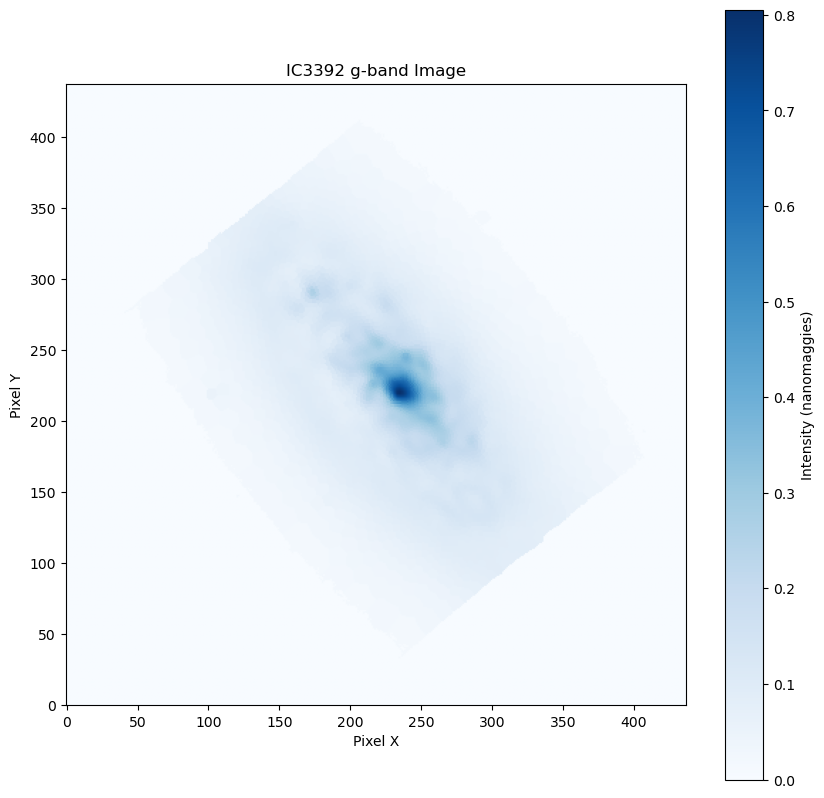

maximum value in g-band flux: 0.8056612
minimum value in g-band flux: 0.0
maximum value in r-band flux: 1.9264852
minimum value in r-band flux: 0.0
maximum value in i-band flux: 3.0153296
minimum value in i-band flux: 0.0
maximum value in h-band flux: 3.5641413
minimum value in h-band flux: 0.0
maximum value in g-band flux: (np.int64(220), np.int64(234))
maximum value in r-band flux: (np.int64(219), np.int64(233))
maximum value in i-band flux: (np.int64(219), np.int64(233))
maximum value in h-band flux: (np.int64(218), np.int64(233))


In [2]:
# Load the FITS file (update the filename as needed)
filename = "IC3392_legacy_voronoi_binned.fits"
object_name = filename.split('_')[0]
hdul = fits.open(filename)

# Display the structure of the FITS file
hdul.info()

# Assuming the image data is in the primary HDU (index 0)
data = hdul[2].data

# make all the nan values to 0
data[np.isnan(data)] = 0
# Check the shape of the data
print("Shape of the data:", data.shape)

# Optionally, print header information to see details about the observation
header = hdul[2].header
print(header)

# Close the FITS file after loading data (optional but recommended)
hdul.close()

g_band_flux = data[0]  # Assuming the first slice is the g-band flux
r_band_flux = data[1]  # Assuming the first slice is the r-band flux
i_band_flux = data[2]  # Assuming the second slice is the i-band flux
h_band_flux = data[3]  # Assuming the second slice is the h-band flux

# Plot the data using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(g_band_flux, cmap='Blues', origin='lower')
plt.colorbar(label='Intensity (nanomaggies)')
plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Check satruration
print("maximum value in g-band flux:", np.nanmax(g_band_flux))
print("minimum value in g-band flux:", np.nanmin(g_band_flux))
print("maximum value in r-band flux:", np.nanmax(r_band_flux))
print("minimum value in r-band flux:", np.nanmin(r_band_flux))
print("maximum value in i-band flux:", np.nanmax(i_band_flux))
print("minimum value in i-band flux:", np.nanmin(i_band_flux))
print("maximum value in h-band flux:", np.nanmax(h_band_flux))
print("minimum value in h-band flux:", np.nanmin(h_band_flux))
# localize the maxinum value
print("maximum value in g-band flux:", np.unravel_index(np.argmax(g_band_flux), g_band_flux.shape))
print("maximum value in r-band flux:", np.unravel_index(np.argmax(r_band_flux), r_band_flux.shape))
print("maximum value in i-band flux:", np.unravel_index(np.argmax(i_band_flux), i_band_flux.shape))
print("maximum value in h-band flux:", np.unravel_index(np.argmax(h_band_flux), h_band_flux.shape))

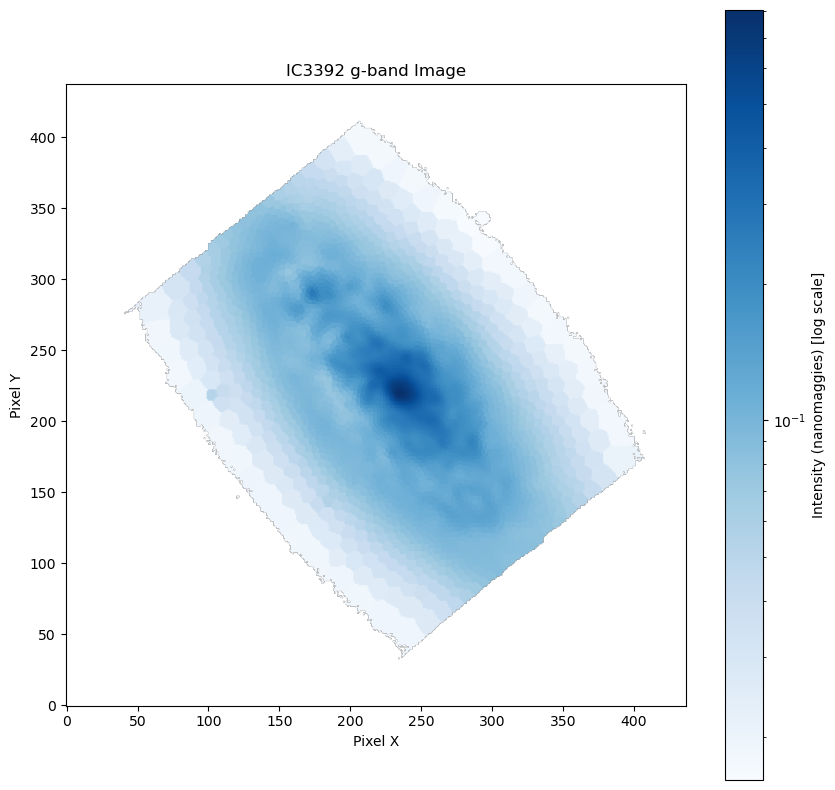

In [3]:
plt.figure(figsize=(10, 10))
# use only positive values for log scaling
vmin = g_band_flux[g_band_flux > 0].min()
vmax = g_band_flux.max()
im = plt.imshow(g_band_flux, cmap='Blues', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Intensity (nanomaggies) [log scale]')

plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

Extinction for IC3392: {'g': 0.11859660000000001, 'r': 0.0798885, 'i': 0.05874480000000001, 'h': 0.0369}
g-band galactic extinction correction applied
r-band galactic extinction correction applied
i-band galactic extinction correction applied
h-band galactic extinction correction applied


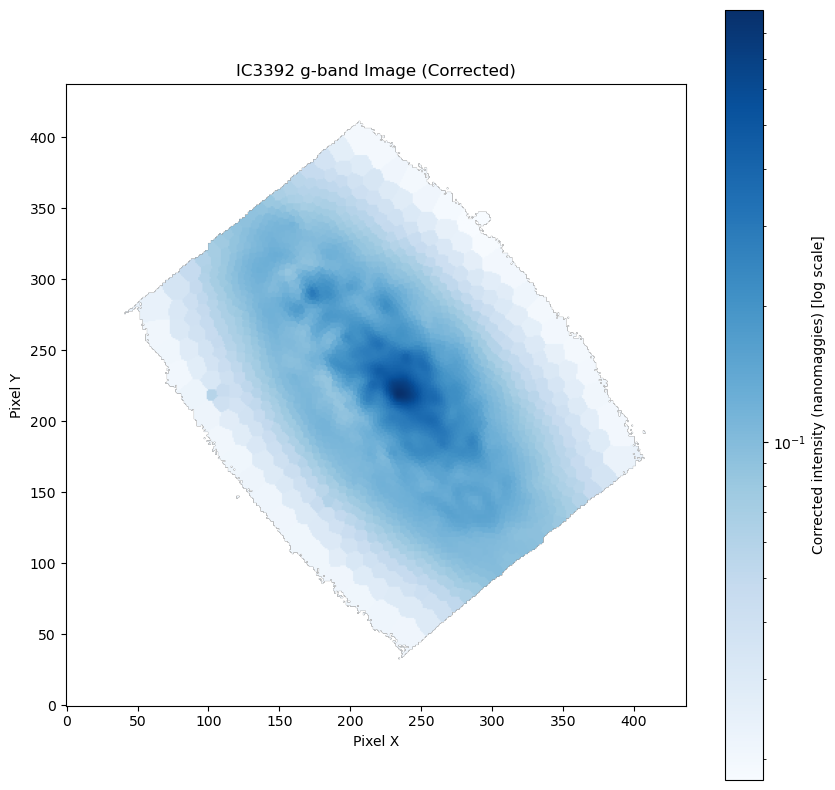

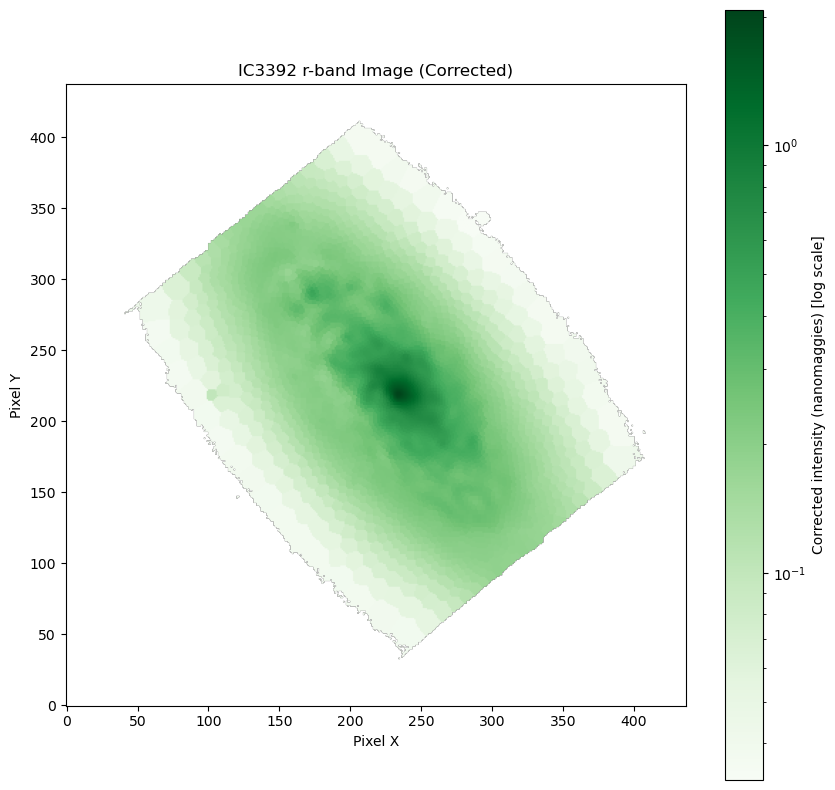

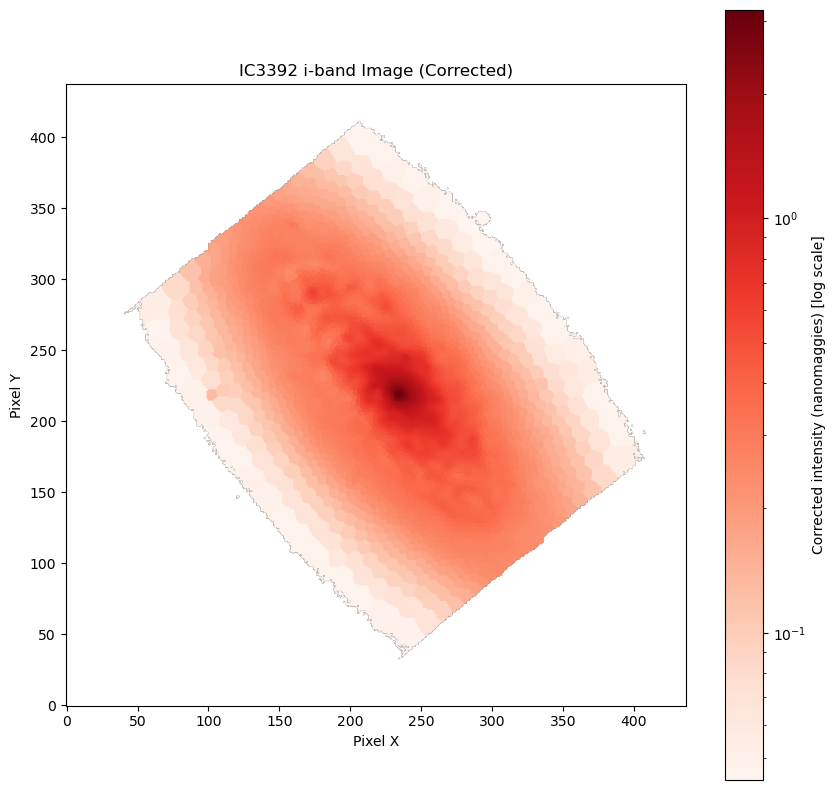

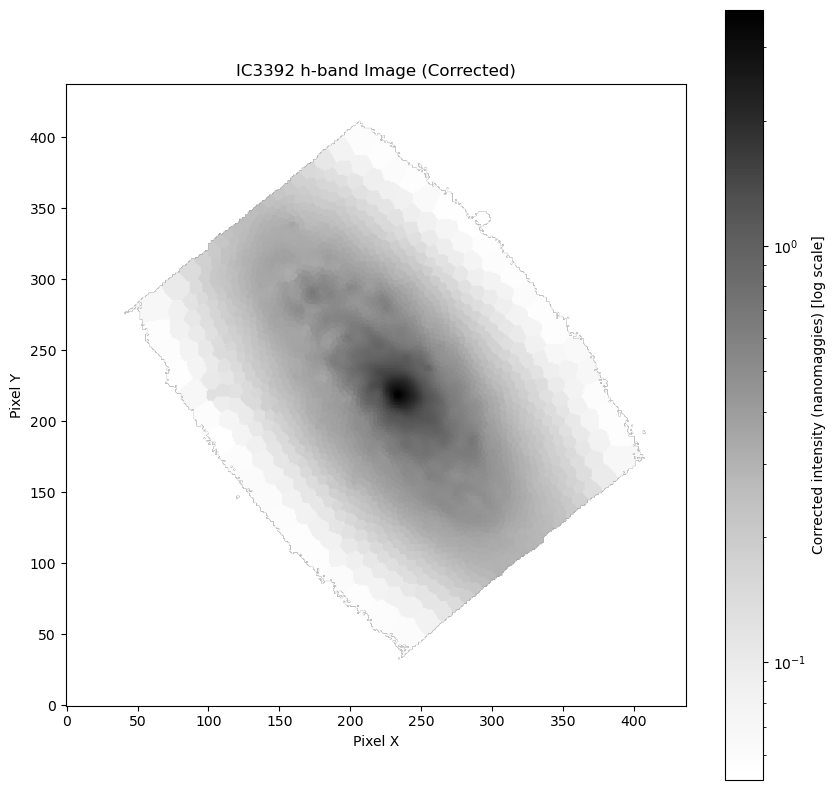

In [4]:
# correction for galactic extinction
# Universal E(B-V) lookup (Corteste et al. 2012)
Extinction_lookup = {
    "IC3392": 0.0369,
    "NGC4383": 0.0237, 
    "NGC4501": 0.0380, 
    "NGC4192": 0.0350, 
}
Extinction = Extinction_lookup.get(object_name, 0.030)  # Default to 0.030 if not found

# Bandpass lookup (https://www.legacysurvey.org/dr9/catalogs/#galactic-extinction-coefficients)
# These coefficients are 𝐴/𝐸(𝐵−𝑉) = 3.995, 3.214, 2.165, 1.592, 1.211, 1.064 for the DECam 𝑢griz𝑌 filters
Extinction_coefficients = {
    # "u": 3.995,
    "g": 3.214,
    "r": 2.165,
    "i": 1.592,
    # "z": 1.211,
    # "Y": 1.064,
    "h": 1.000,
}
# Calculate the extinction for each band for the input object
def calculate_extinction(object_name, Extintion, Extintion_coefficients):
    extinction = {}
    for band, coeff in Extintion_coefficients.items():
        extinction[band] = coeff * Extintion
    return extinction
extinction = calculate_extinction(object_name, Extinction, Extinction_coefficients)
print(f"Extinction for {object_name}: {extinction}")

# Apply the extinction correction to the g-band and i-band flux
def apply_extinction_correction(flux, extinction, band):
    coeff = extinction[band]
    corrected_flux = flux * 10**(0.4 * coeff)
    return corrected_flux
g_band_flux_corrected = apply_extinction_correction(g_band_flux, extinction, "g")
r_band_flux_corrected = apply_extinction_correction(r_band_flux, extinction, "r")
i_band_flux_corrected = apply_extinction_correction(i_band_flux, extinction, "i")
h_band_flux_corrected = apply_extinction_correction(h_band_flux, extinction, "h")  
print("g-band galactic extinction correction applied")
print("r-band galactic extinction correction applied")
print("i-band galactic extinction correction applied")
print("h-band galactic extinction correction applied") 

# Plot the corrected g-band image
plt.figure(figsize=(10, 10))
vmin = g_band_flux_corrected[g_band_flux_corrected > 0].min()
vmax = g_band_flux_corrected.max()
im = plt.imshow(g_band_flux_corrected, cmap='Blues', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Corrected intensity (nanomaggies) [log scale]')
plt.title(f"{object_name} g-band Image (Corrected)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the corrected r-band image
plt.figure(figsize=(10, 10))
vmin = r_band_flux_corrected[r_band_flux_corrected > 0].min()
vmax = r_band_flux_corrected.max()
im = plt.imshow(r_band_flux_corrected, cmap='Greens', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Corrected intensity (nanomaggies) [log scale]')
plt.title(f"{object_name} r-band Image (Corrected)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the corrected i-band image
plt.figure(figsize=(10, 10))
vmin = i_band_flux_corrected[i_band_flux_corrected > 0].min()
vmax = i_band_flux_corrected.max()
im = plt.imshow(i_band_flux_corrected, cmap='Reds', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Corrected intensity (nanomaggies) [log scale]')
plt.title(f"{object_name} i-band Image (Corrected)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the corrected h-band image
plt.figure(figsize=(10, 10))
vmin = h_band_flux_corrected[h_band_flux_corrected > 0].min()
vmax = h_band_flux_corrected.max()
im = plt.imshow(h_band_flux_corrected, cmap='Grays', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Corrected intensity (nanomaggies) [log scale]')
plt.title(f"{object_name} h-band Image (Corrected)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [5]:
# # Get valid flux (negative values are set to nan)
# g_band_flux_corrected[g_band_flux_corrected <= 0] = np.nan
# r_band_flux_corrected[r_band_flux_corrected <= 0] = np.nan
# i_band_flux_corrected[i_band_flux_corrected <= 0] = np.nan
# h_band_flux_corrected[h_band_flux_corrected <= 0] = np.nan

# # 1) Open the reprojected/voronoi‐binned FITS and grab its FLUX header
# src_fn   = "IC3392_legacy_voronoi_binned.fits"
# out_fn   = "IC3392_legacy_voronoi_binned_extended.fits"
# hdl_src  = fits.open(src_fn)
# flux_hdr = hdl_src['FLUX'].header       # this header stores your correct 2D WCS
# hdl_src.close()

# # 2) Stack your four corrected bands into a (4, ny, nx) cube
# #    (you’ve already computed these 2D arrays)
# calibrated_stack = np.stack([
#     g_band_flux_corrected,
#     r_band_flux_corrected,
#     i_band_flux_corrected,
#     h_band_flux_corrected
# ], axis=0).astype(np.float32)

# # 3) Create a new ImageHDU *with* the FLUX header
# hdu_cal = fits.ImageHDU(
#     data=calibrated_stack,
#     header=flux_hdr.copy(),            # copy so we don’t overwrite the original
#     name='FLUX_CALIBRATED'
# )
# hdu_cal.header['BUNIT'] = 'nanomaggies'  # carry over or set whatever unit you like

# # 4) Re-open the original file, append the new HDU, and write out
# hdl_out = fits.open(src_fn)
# hdl_out.append(hdu_cal)
# hdl_out.writeto(out_fn, overwrite=True)
# hdl_out.close()

# print(f"Extended FITS saved to {out_fn} with matching WCS.")


nanomaggies to magnitudes conversion done.
g-band magnitude range: 26.87 to 22.62
r-band magnitude range: 26.21 to 21.71
i-band magnitude range: 25.89 to 21.24
h-band magnitude range: 25.71 to 21.08


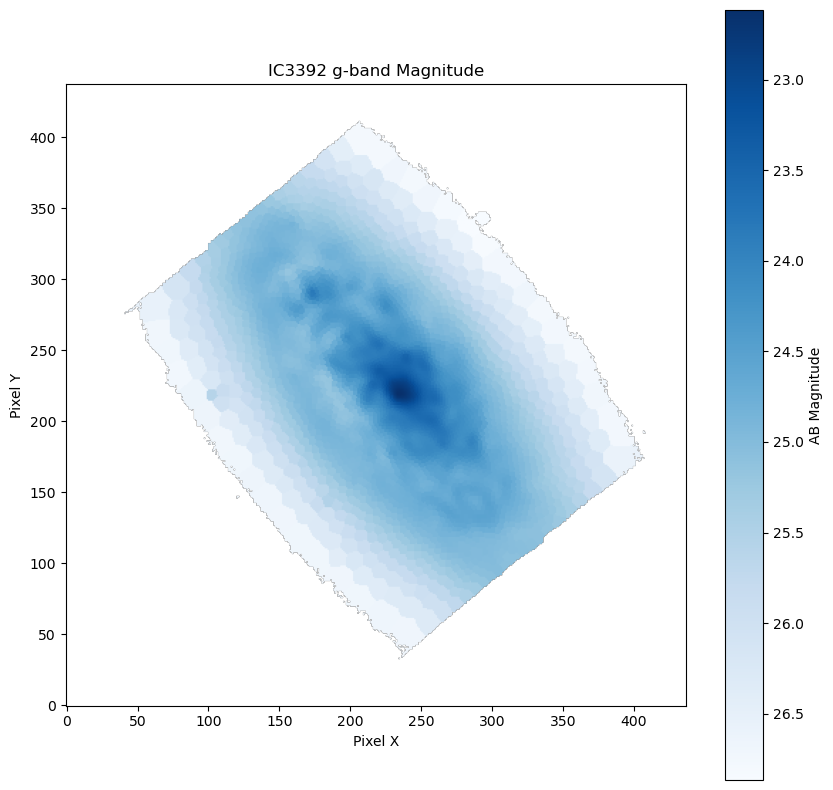

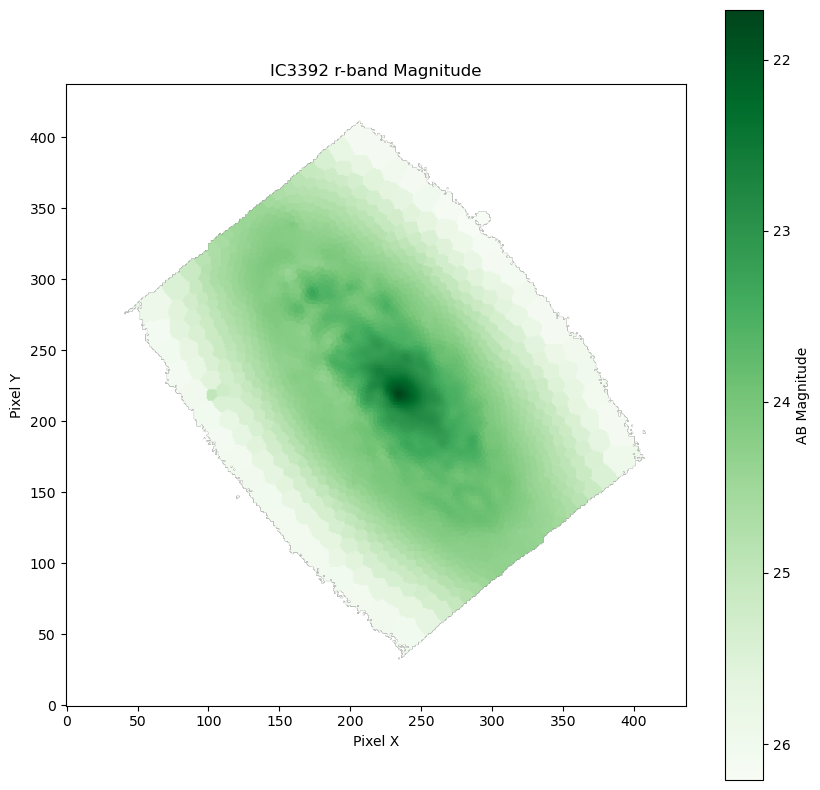

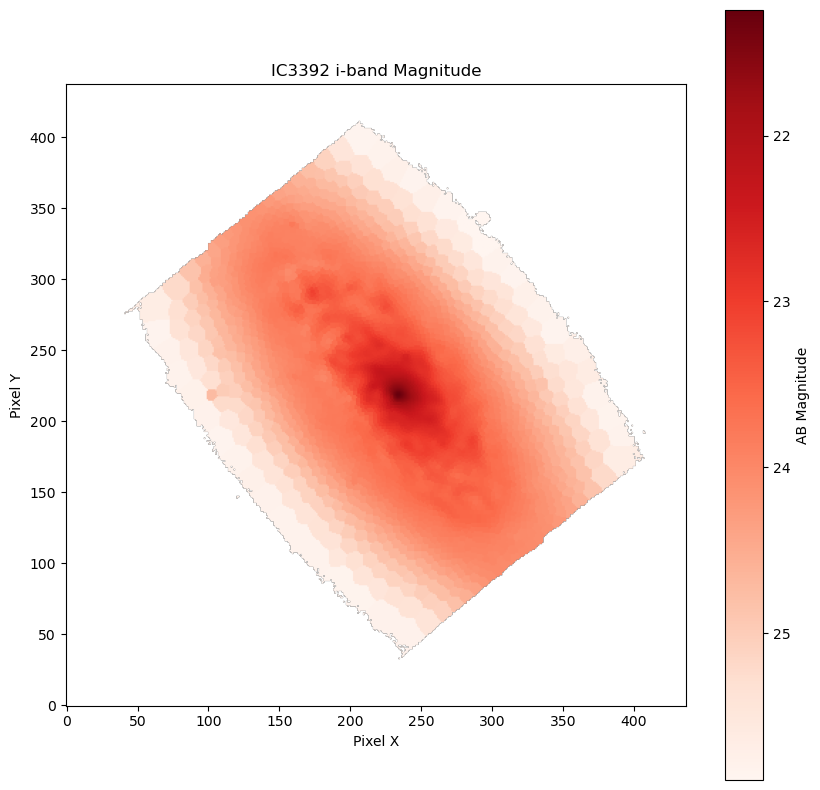

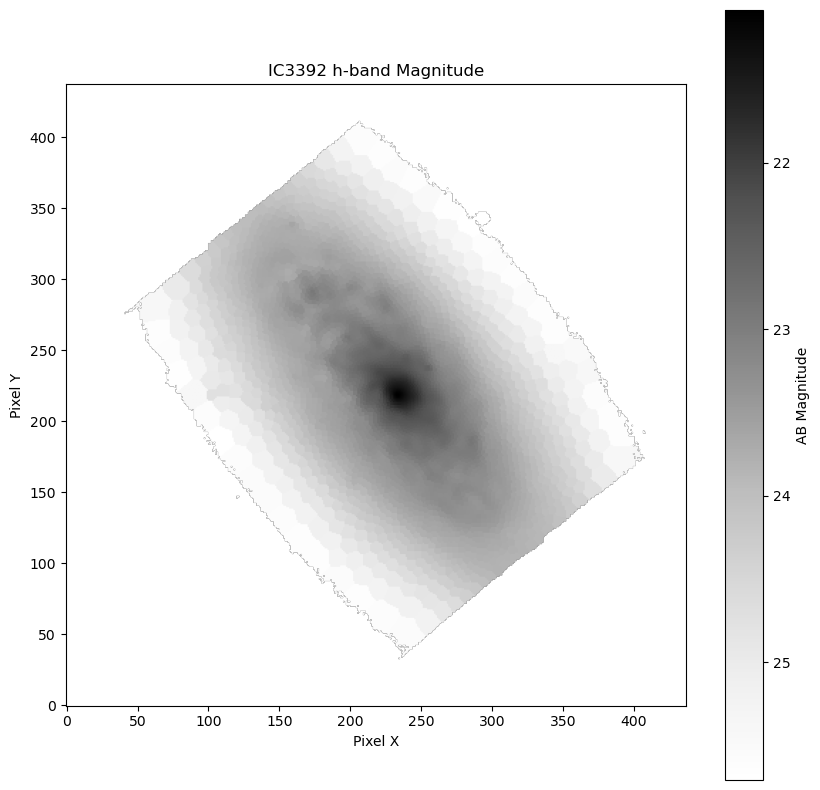

In [6]:
# Check background noise level
# g_band_flux_noise = np.max(np.abs(g_band_flux_corrected[g_band_flux<0]))
# r_band_flux_noise = np.max(np.abs(r_band_flux_corrected[r_band_flux<0]))
# i_band_flux_noise = np.max(np.abs(i_band_flux_corrected[i_band_flux<0]))
# h_band_flux_noise = np.max(np.abs(h_band_flux_corrected[h_band_flux<0]))
# print(f"g-band noise level: {g_band_flux_noise}")
# print(f"r-band noise level: {r_band_flux_noise}")
# print(f"i-band noise level: {i_band_flux_noise}")
# print(f"h-band noise level: {h_band_flux_noise}")

# Get valid flux (negative values are set to nan)
g_band_flux_corrected[g_band_flux_corrected <= 0] = np.nan
r_band_flux_corrected[r_band_flux_corrected <= 0] = np.nan
i_band_flux_corrected[i_band_flux_corrected <= 0] = np.nan
h_band_flux_corrected[h_band_flux_corrected <= 0] = np.nan

# Convert nanomaggies to magnitudes
# The conversion from linear fluxes to magnitudes is 𝑚=22.5−2.5log10(flux)
g_band_magnitude = 22.5 - 2.5 * np.log10(g_band_flux_corrected)
r_band_magnitude = 22.5 - 2.5 * np.log10(r_band_flux_corrected)
i_band_magnitude = 22.5 - 2.5 * np.log10(i_band_flux_corrected)
h_band_magnitude = 22.5 - 2.5 * np.log10(h_band_flux_corrected)

print("nanomaggies to magnitudes conversion done.")
# Check the range of magnitudes
print(f"g-band magnitude range: {np.nanmax(g_band_magnitude):.2f} to {np.nanmin(g_band_magnitude):.2f}")
print(f"r-band magnitude range: {np.nanmax(r_band_magnitude):.2f} to {np.nanmin(r_band_magnitude):.2f}")
print(f"i-band magnitude range: {np.nanmax(i_band_magnitude):.2f} to {np.nanmin(i_band_magnitude):.2f}")
print(f"h-band magnitude range: {np.nanmax(h_band_magnitude):.2f} to {np.nanmin(h_band_magnitude):.2f}")

# Plot the g-band and i-band magnitudes
plt.figure(figsize=(10, 10))
plt.imshow(g_band_magnitude, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(r_band_magnitude, cmap='Greens_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} r-band Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(i_band_magnitude, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(h_band_magnitude, cmap='Greys_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} h-band Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

g-band isophotal threshold in pixel scale: 27.99 mag/pixel^2
r-band isophotal threshold in pixel scale: 27.49 mag/pixel^2
i-band isophotal threshold in pixel scale: 26.99 mag/pixel^2
h-band isophotal threshold in pixel scale: 26.49 mag/pixel^2


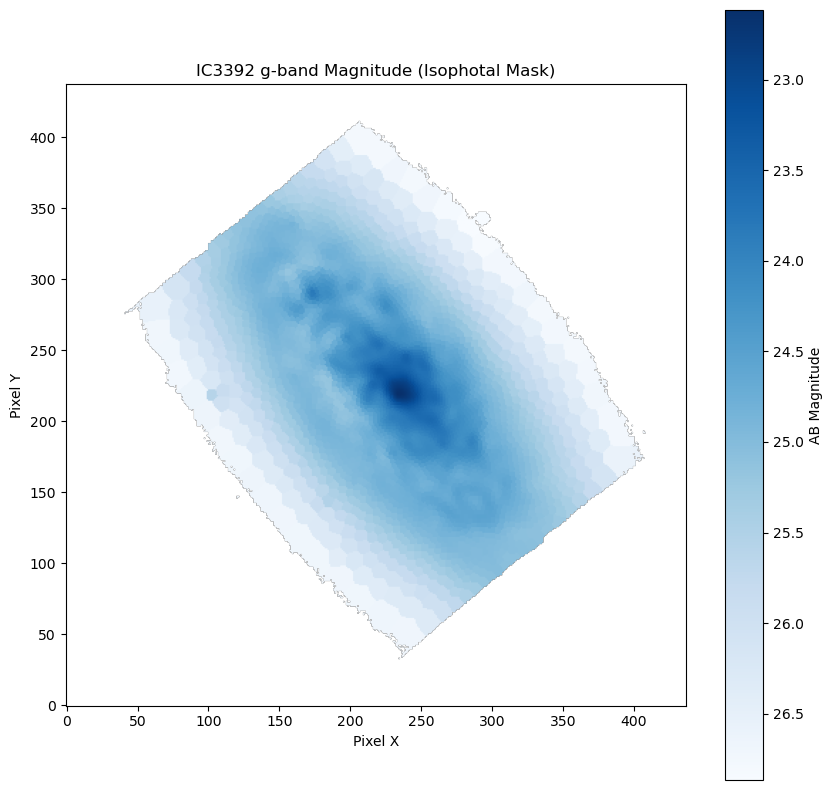

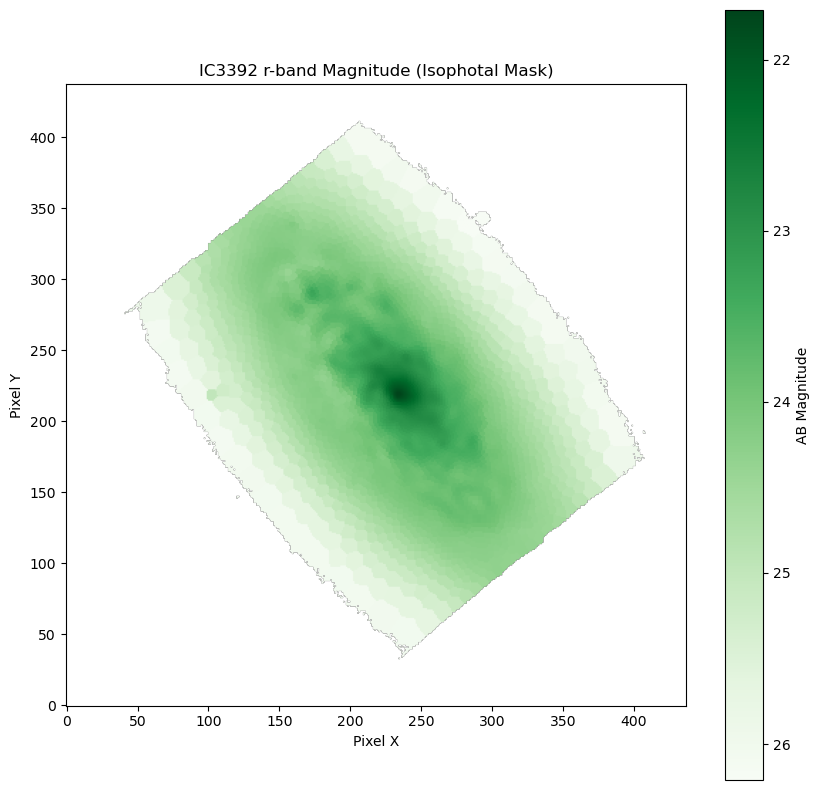

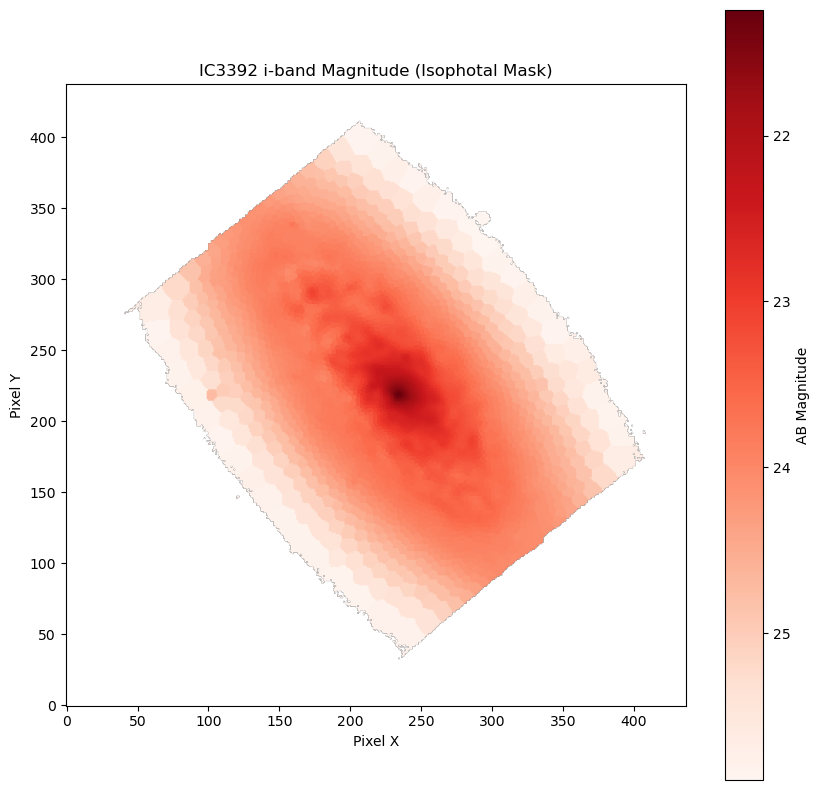

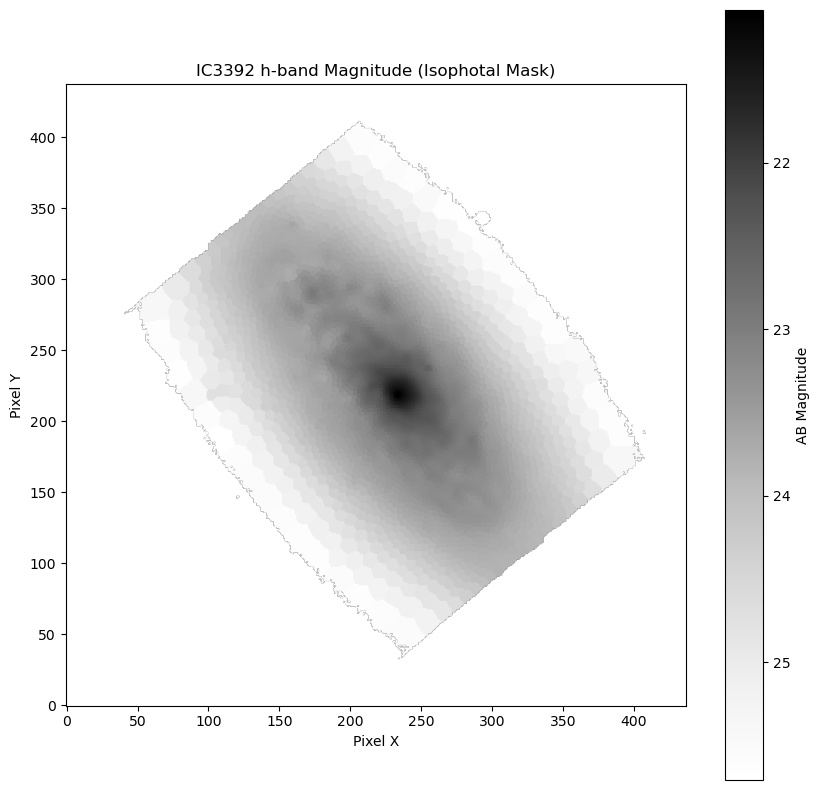

In [7]:
# g-band isophotal threshold: 24.5 mag/arcsec^2
# i-band isophotal threshold: 23.5 mag/arcsec^2
# with the pixel scale of 0.262 arcsec/pixel
g_band_limit = 24.5
r_band_limit = 24.0
i_band_limit = 23.5
h_band_limit = 23.0
pixel_scale = 0.262  # arcsec/pixel

# Set to 99 if data in binning
g_band_limit = 24.5
r_band_limit = 24.0
i_band_limit = 23.5
h_band_limit = 23.0
pixel_scale = 0.2  # arcsec/pixel

# Convert mag/arcsec^2 to magnitude at each pixel
g_band_limit_pixel = g_band_limit - 2.5 * np.log10(pixel_scale**2) 
r_band_limit_pixel = r_band_limit - 2.5 * np.log10(pixel_scale**2) 
i_band_limit_pixel = i_band_limit - 2.5 * np.log10(pixel_scale**2)
h_band_limit_pixel = h_band_limit - 2.5 * np.log10(pixel_scale**2)
print(f"g-band isophotal threshold in pixel scale: {g_band_limit_pixel:.2f} mag/pixel^2")
print(f"r-band isophotal threshold in pixel scale: {r_band_limit_pixel:.2f} mag/pixel^2")
print(f"i-band isophotal threshold in pixel scale: {i_band_limit_pixel:.2f} mag/pixel^2")
print(f"h-band isophotal threshold in pixel scale: {h_band_limit_pixel:.2f} mag/pixel^2")

# Create a mask for the g-band and i-band images in the isophotal limit
g_band_isophotal = np.where(
    g_band_magnitude < g_band_limit_pixel,
    g_band_magnitude,
    np.nan
)
r_band_isophotal = np.where(
    r_band_magnitude < r_band_limit_pixel,
    r_band_magnitude,
    np.nan
)
i_band_isophotal = np.where(
    i_band_magnitude < i_band_limit_pixel,
    i_band_magnitude,
    np.nan
)
h_band_isophotal = np.where(
    h_band_magnitude < h_band_limit_pixel,
    h_band_magnitude,
    np.nan
)

# Plot the isophotal mask for g-band
plt.figure(figsize=(10, 10))
plt.imshow(g_band_isophotal, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band Magnitude (Isophotal Mask)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the isophotal mask for r-band
plt.figure(figsize=(10, 10))
plt.imshow(r_band_isophotal, cmap='Greens_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} r-band Magnitude (Isophotal Mask)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the isophotal mask for i-band    
plt.figure(figsize=(10, 10))
plt.imshow(i_band_isophotal, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band Magnitude (Isophotal Mask)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the isophotal mask for h-band
plt.figure(figsize=(10, 10))
plt.imshow(h_band_isophotal, cmap='Greys_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} h-band Magnitude (Isophotal Mask)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

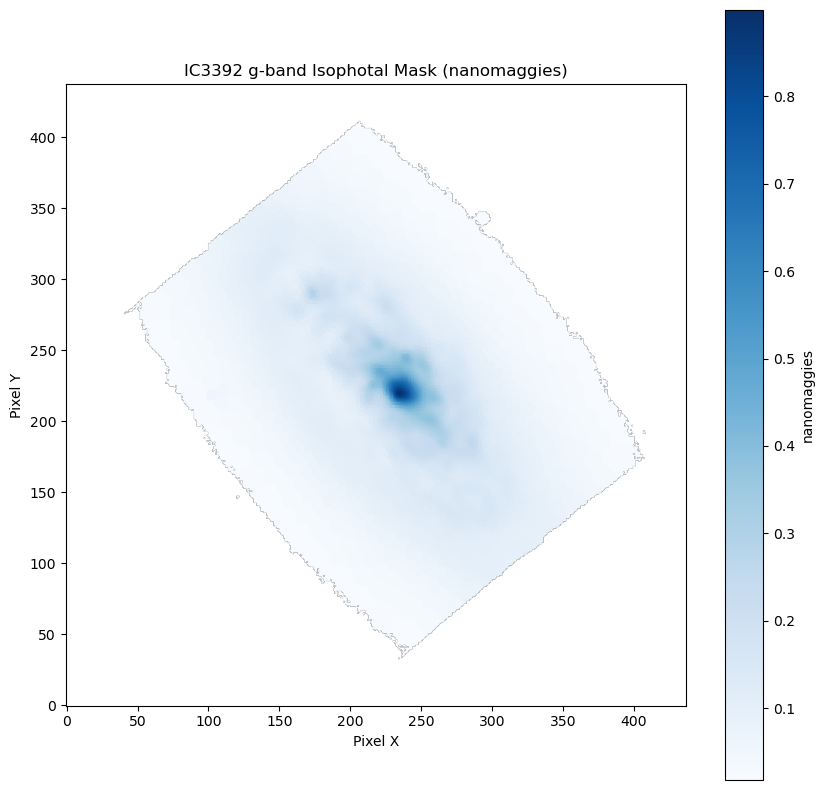

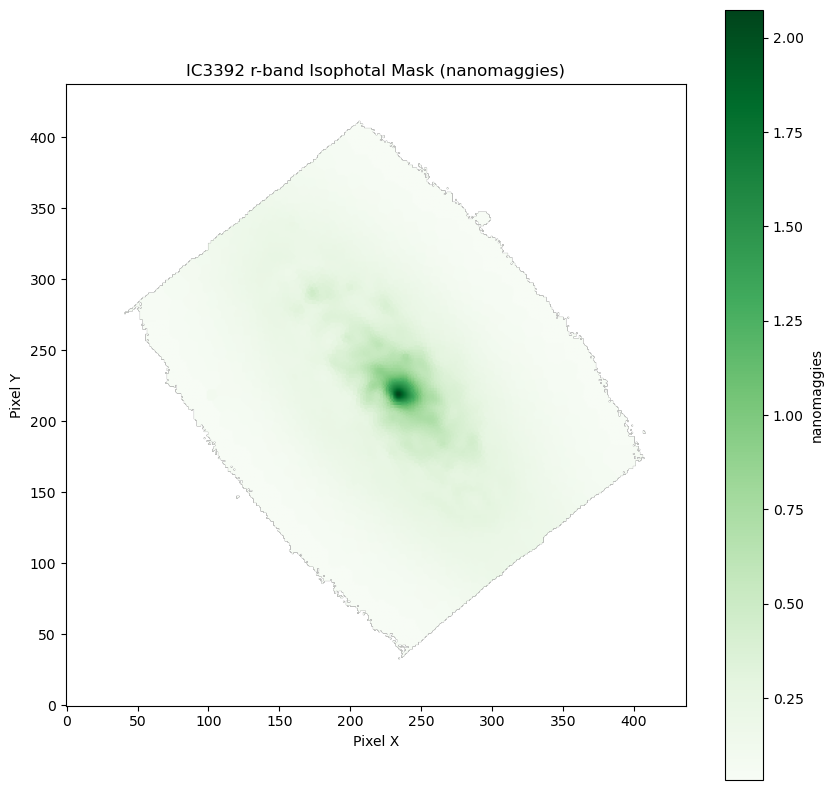

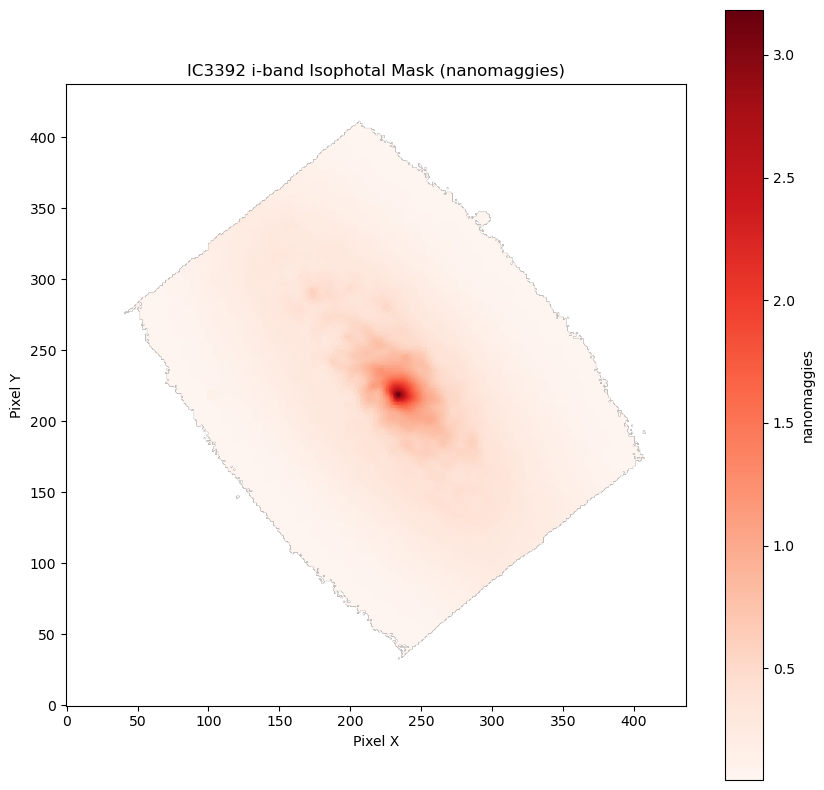

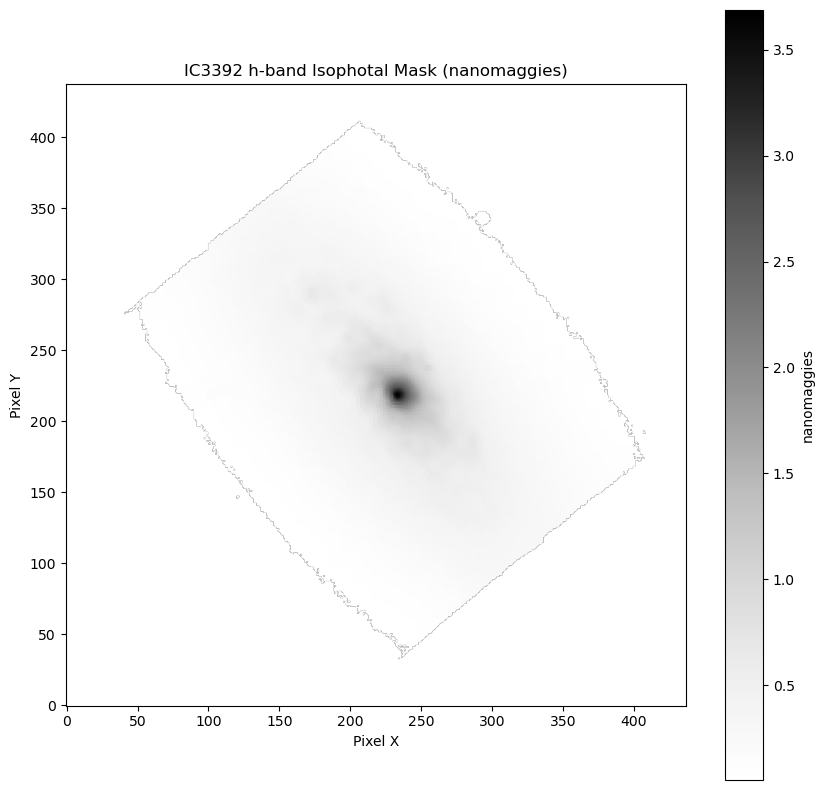

In [8]:
# convert isophotal magnitude back to nanomaggies
def magnitude_to_nanomaggies(magnitude):
    return 10**((22.5 - magnitude) / 2.5)
g_band_isophotal_nanomaggies = magnitude_to_nanomaggies(g_band_isophotal)
r_band_isophotal_nanomaggies = magnitude_to_nanomaggies(r_band_isophotal)
i_band_isophotal_nanomaggies = magnitude_to_nanomaggies(i_band_isophotal)
h_band_isophotal_nanomaggies = magnitude_to_nanomaggies(h_band_isophotal)
# Plot the isophotal mask for g-band in nanomaggies
plt.figure(figsize=(10, 10))
plt.imshow(g_band_isophotal_nanomaggies, cmap='Blues', origin='lower')
cbar = plt.colorbar(label='nanomaggies')
# cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band Isophotal Mask (nanomaggies)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the isophotal mask for r-band in nanomaggies
plt.figure(figsize=(10, 10))
plt.imshow(r_band_isophotal_nanomaggies, cmap='Greens', origin='lower')
cbar = plt.colorbar(label='nanomaggies')
# cbar.ax.invert_yaxis()
plt.title(f"{object_name} r-band Isophotal Mask (nanomaggies)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the isophotal mask for i-band in nanomaggies
plt.figure(figsize=(10, 10))
plt.imshow(i_band_isophotal_nanomaggies, cmap='Reds', origin='lower')
cbar = plt.colorbar(label='nanomaggies')
# cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band Isophotal Mask (nanomaggies)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the isophotal mask for h-band in nanomaggies
plt.figure(figsize=(10, 10))
plt.imshow(h_band_isophotal_nanomaggies, cmap='Greys', origin='lower')
cbar = plt.colorbar(label='nanomaggies')
# cbar.ax.invert_yaxis()
plt.title(f"{object_name} h-band Isophotal Mask (nanomaggies)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()



In [9]:
22.5 - 2.5 * np.log10(np.nansum(r_band_isophotal_nanomaggies))

np.float32(12.234194)

In [10]:
# 1) Open the reprojected/voronoi‐binned FITS and grab its FLUX header
src_fn   = "IC3392_legacy_voronoi_binned.fits"
out_fn   = "IC3392_legacy_voronoi_binned_extended.fits"
hdl_src  = fits.open(src_fn)
flux_hdr = hdl_src['FLUX'].header       # this header stores your correct 2D WCS
hdl_src.close()

# 2) Stack your four corrected bands into a (4, ny, nx) cube
#    (you’ve already computed these 2D arrays)
calibrated_stack = np.stack([
    g_band_isophotal_nanomaggies,
    r_band_isophotal_nanomaggies,
    i_band_isophotal_nanomaggies,
    h_band_isophotal_nanomaggies
], axis=0).astype(np.float32)

# 3) Create a new ImageHDU *with* the FLUX header
hdu_cal = fits.ImageHDU(
    data=calibrated_stack,
    header=flux_hdr.copy(),            # copy so we don’t overwrite the original
    name='FLUX_CALIBRATED'
)
hdu_cal.header['BUNIT'] = 'nanomaggies'  # carry over or set whatever unit you like

# 4) Re-open the original file, append the new HDU, and write out
hdl_out = fits.open(src_fn)
hdl_out.append(hdu_cal)
hdl_out.writeto(out_fn, overwrite=True)
hdl_out.close()

print(f"Extended FITS saved to {out_fn} with matching WCS.")

Extended FITS saved to IC3392_legacy_voronoi_binned_extended.fits with matching WCS.


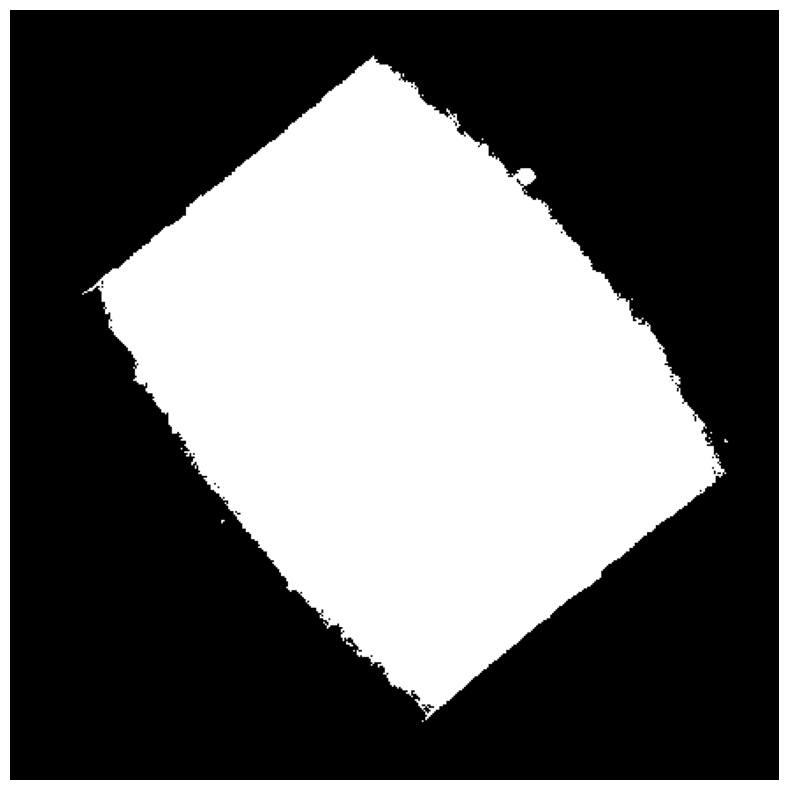

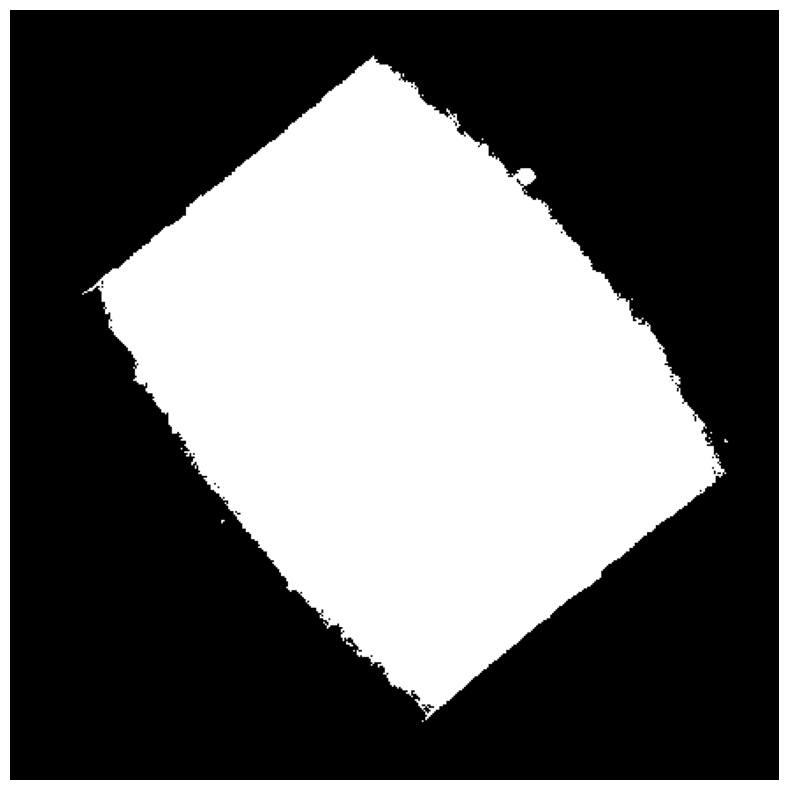

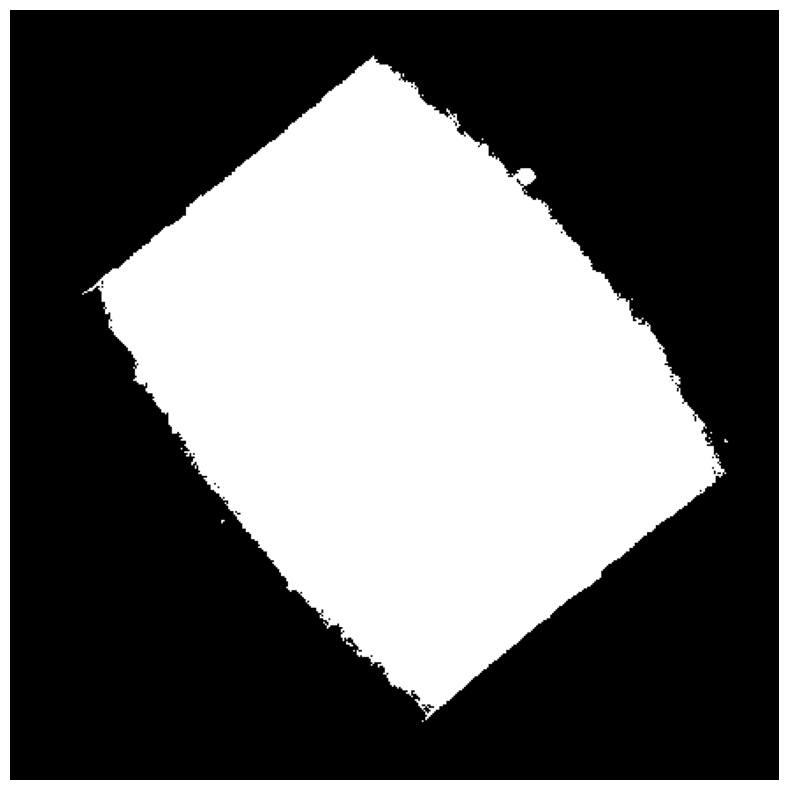

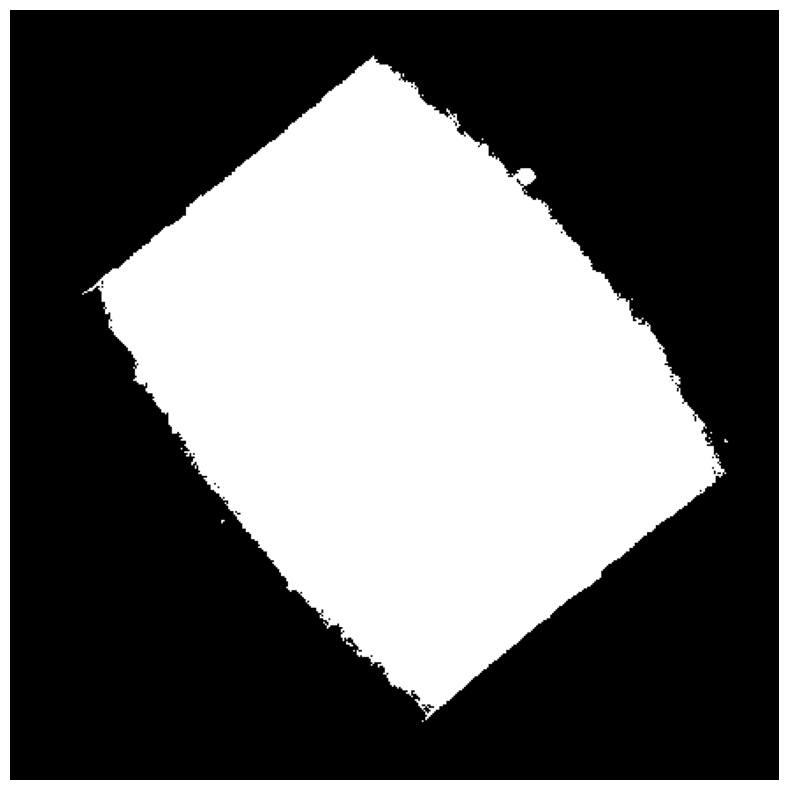

In [11]:
# build a binary mask: non-nan → 1 (white), nan → 0 (black)
binary_g = np.where(np.isnan(g_band_isophotal), 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(binary_g, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.axis('off')
plt.show()
binary_r = np.where(np.isnan(r_band_isophotal), 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(binary_r, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.axis('off')
plt.show()
binary_i = np.where(np.isnan(i_band_isophotal), 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(binary_i, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.axis('off')
plt.show()
binary_h = np.where(np.isnan(h_band_isophotal), 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(binary_h, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.axis('off')
plt.show()


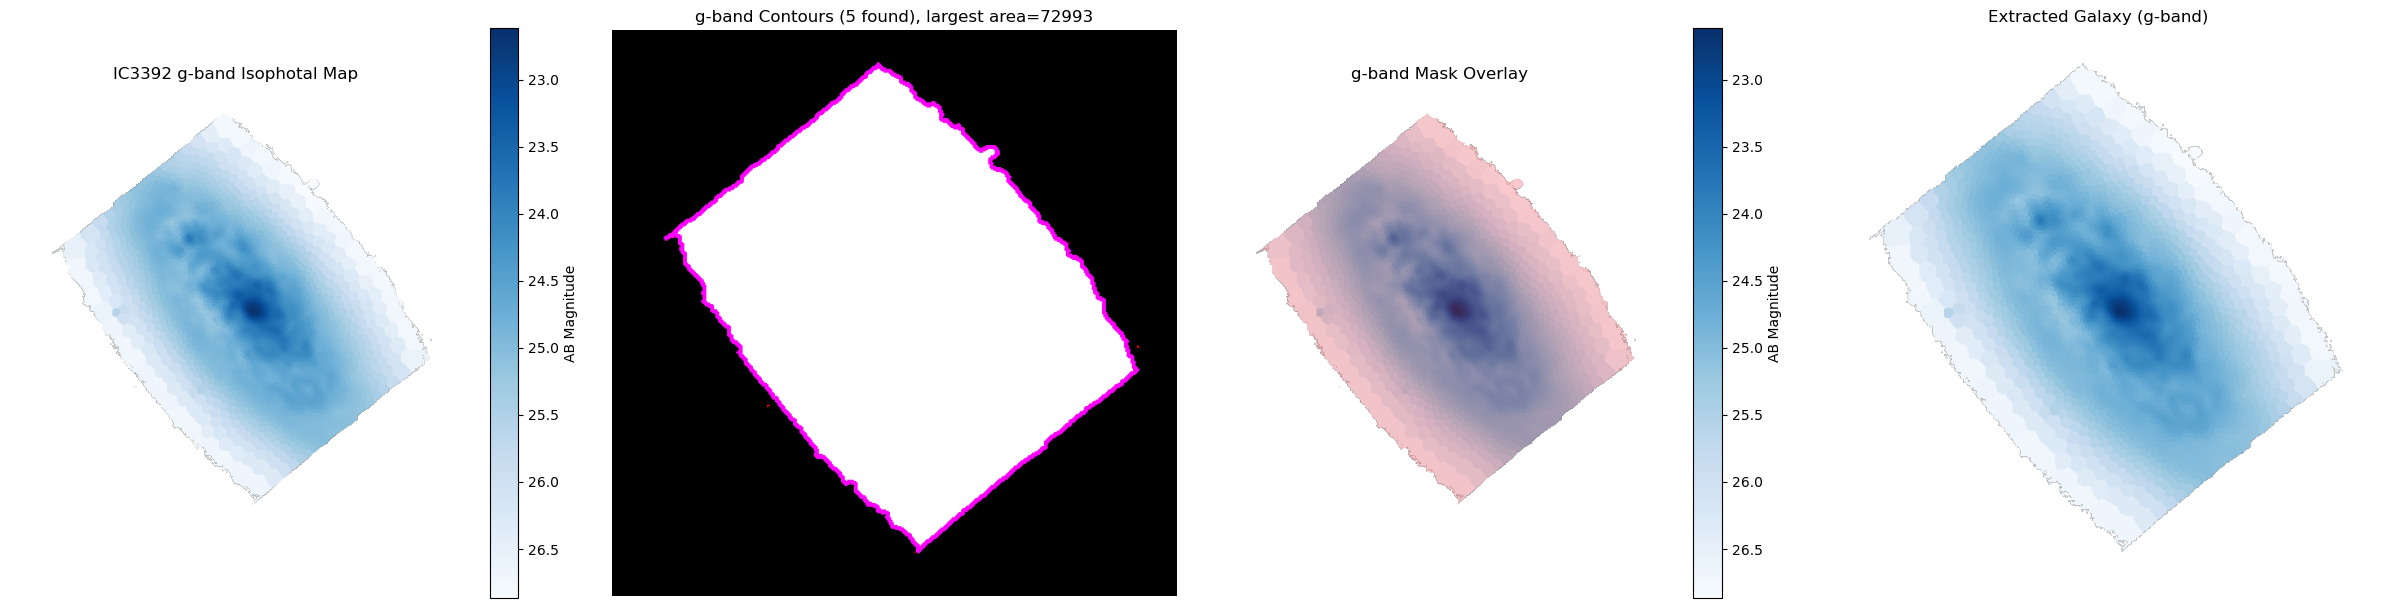

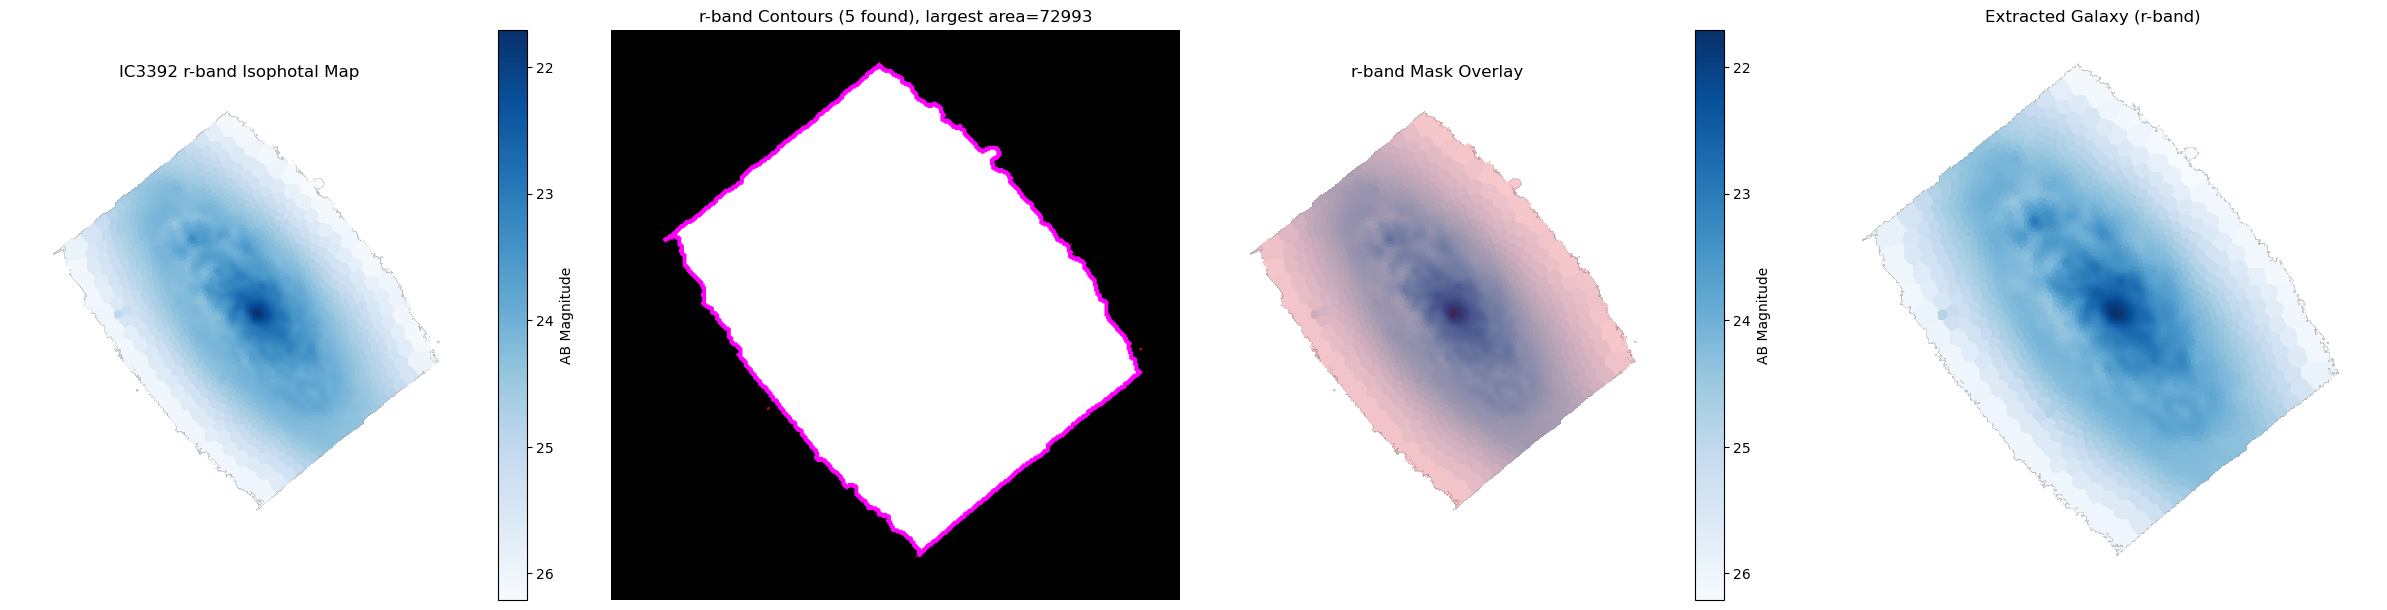

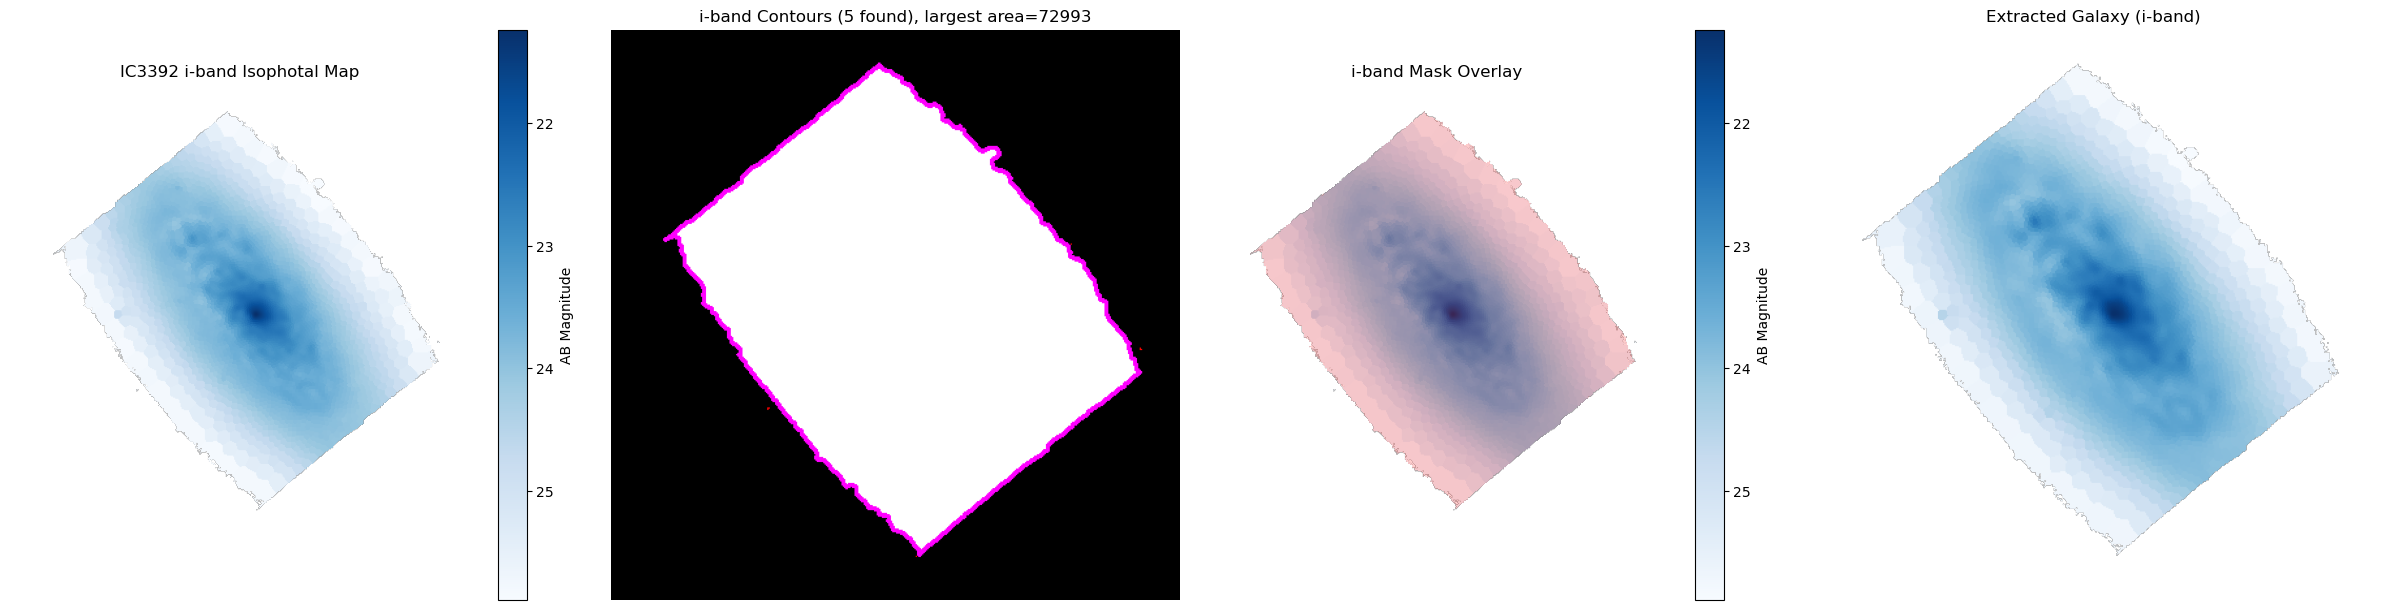

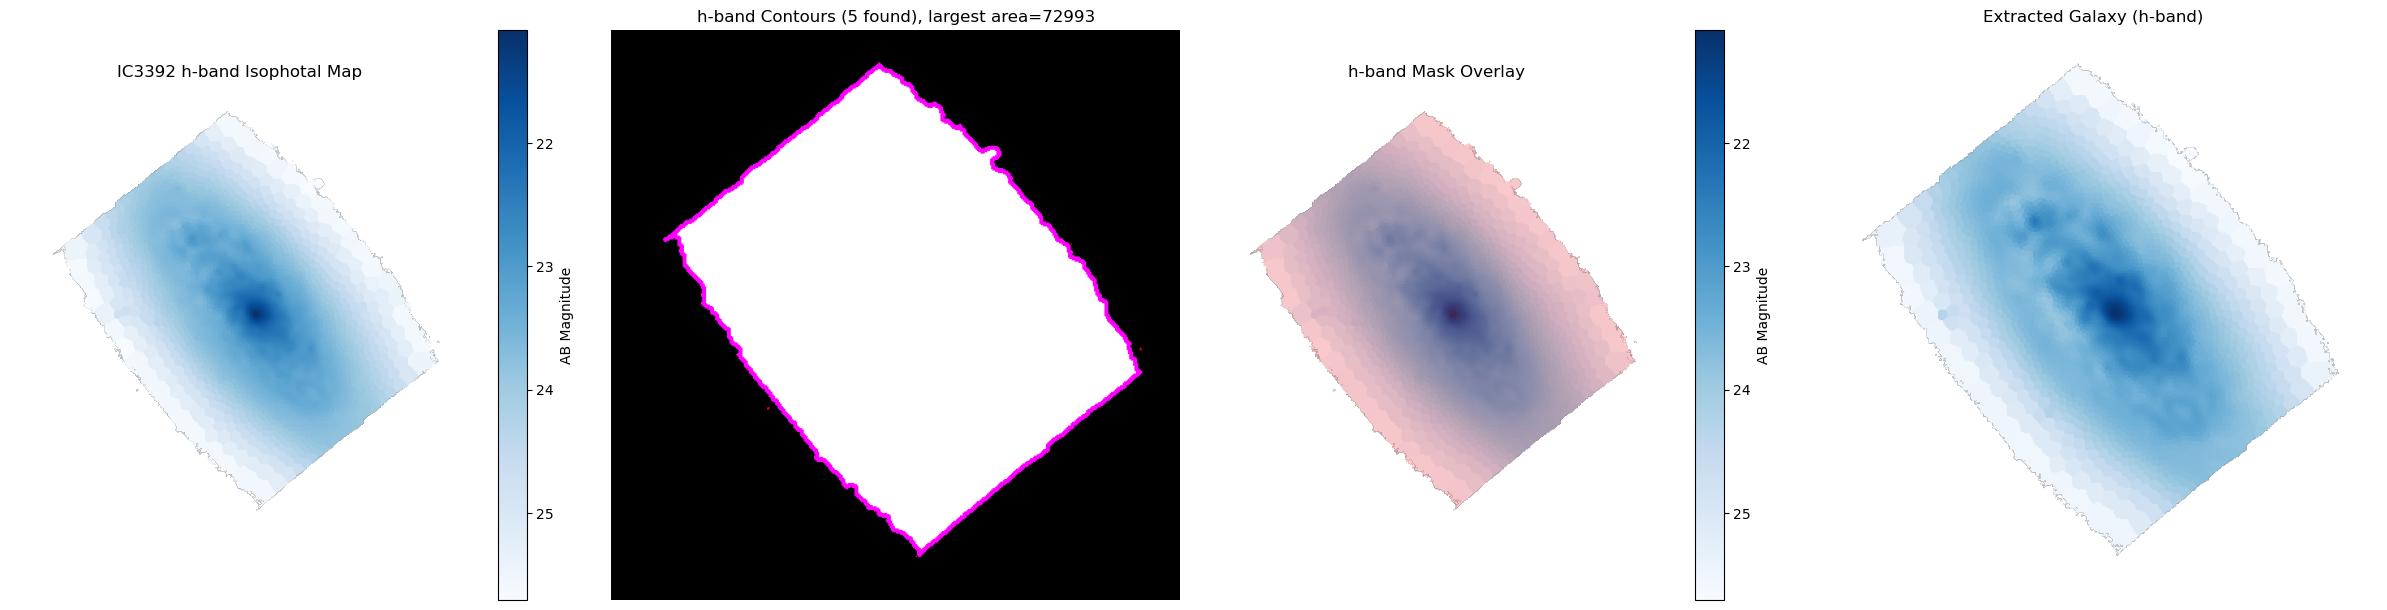

In [12]:
class GalaxyExtractor:
    def __init__(self, data, binary_mask, isophotal_map, band_name, kernel_size=5):
        """
        data:          2D numpy array from FITS
        binary_mask:   2D 0/1 mask
        isophotal_map: 2D array for overlay
        band_name:     'g' or 'i'
        kernel_size:   diameter of morphological element
        """
        self.data    = data
        self.mask01  = binary_mask
        self.iso     = isophotal_map
        self.name    = band_name
        self.kernel  = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (kernel_size, kernel_size)
        )

    def _compute_contours(self):
        m8 = (self.mask01 * 255).astype(np.uint8)
        # optional cleanup:
        # m8 = cv2.erode(m8, self.kernel, iterations=1)
        m8 = cv2.morphologyEx(m8, cv2.MORPH_CLOSE, self.kernel, iterations=1)
        cnts, _ = cv2.findContours(m8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return m8, cnts

    def run(self):
        # Step 1: detect contours
        m8, cnts = self._compute_contours()
        vis = cv2.cvtColor(m8, cv2.COLOR_GRAY2BGR)
        largest = None
        if cnts:
            cv2.drawContours(vis, cnts, -1, (0,0,255), 1)
            largest = max(cnts, key=cv2.contourArea)
            cv2.drawContours(vis, [largest], -1, (255,0,255), 2)
        vis = cv2.flip(vis, 0)

        # Step 2: fill largest contour → mask + extract
        filled = np.zeros_like(m8)
        if largest is not None:
            cv2.drawContours(filled, [largest], -1, 255, thickness=-1)
        galaxy_mask = (filled > 0)
        galaxy = np.zeros_like(self.data)
        galaxy[galaxy_mask] = self.data[galaxy_mask]

        # Step 3: 1×4 plotting
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))

        # Panel 1: isophotal map
        im0 = axes[0].imshow(self.iso, cmap='Blues_r', origin='lower')
        c0  = fig.colorbar(im0, ax=axes[0], label='AB Magnitude')
        c0.ax.invert_yaxis()
        axes[0].set_title(f"{object_name} {self.name}-band Isophotal Map")
        axes[0].set_xlabel("Pixel X");   axes[0].set_ylabel("Pixel Y")
        axes[0].axis('off')

        # Panel 2: contour overlay
        axes[1].imshow(vis[..., ::-1])  # BGR→RGB
        t2 = f"{self.name}-band Contours ({len(cnts)} found)"
        if largest is not None:
            t2 += f", largest area={cv2.contourArea(largest):.0f}"
        axes[1].set_title(t2)
        axes[1].axis('off')

        # Panel 3: mask overlay
        im2 = axes[2].imshow(self.iso, cmap='Blues_r', origin='lower')
        c2  = fig.colorbar(im2, ax=axes[2], label='AB Magnitude')
        c2.ax.invert_yaxis()
        axes[2].imshow(
            np.ma.masked_where(~galaxy_mask, galaxy_mask),
            cmap='autumn', alpha=0.2, origin='lower'
        )
        axes[2].set_title(f"{self.name}-band Mask Overlay")
        axes[2].axis('off')

        # Panel 4: extracted galaxy
        vmin = self.data[self.data > 0].min()
        vmax = self.data.max()
        axes[3].imshow(
            galaxy, cmap='Blues', origin='lower',
            norm=LogNorm(vmin=vmin, vmax=vmax)
        )
        axes[3].set_title(f"Extracted Galaxy ({self.name}-band)")
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        # save for later
        self.galaxy_mask = galaxy_mask
        self.galaxy      = galaxy
        return galaxy_mask, galaxy

# --- Usage example for both g and i bands: ---
# instantiate and run
g_extractor = GalaxyExtractor(data[0], binary_g, g_band_isophotal, 'g')
galaxy_g_mask, galaxy_g = g_extractor.run()
r_extractor = GalaxyExtractor(data[0], binary_r, r_band_isophotal, 'r')
galaxy_r_mask, galaxy_r = r_extractor.run()
i_extractor = GalaxyExtractor(data[0], binary_i, i_band_isophotal, 'i')
galaxy_i_mask, galaxy_i = i_extractor.run()
h_extractor = GalaxyExtractor(data[0], binary_h, h_band_isophotal, 'h')
galaxy_h_mask, galaxy_h = h_extractor.run()

# build a mask of pixels that are not NaN in both isophotal maps
valid_both = (~np.isnan(g_band_isophotal)) & (~np.isnan(r_band_isophotal)) & (~np.isnan(i_band_isophotal) ) & (~np.isnan(h_band_isophotal))

# combine: any pixel found in g _or_ i, but only where both maps are defined
galaxy_combined_mask = (galaxy_g_mask | galaxy_r_mask | galaxy_i_mask | galaxy_h_mask) & valid_both

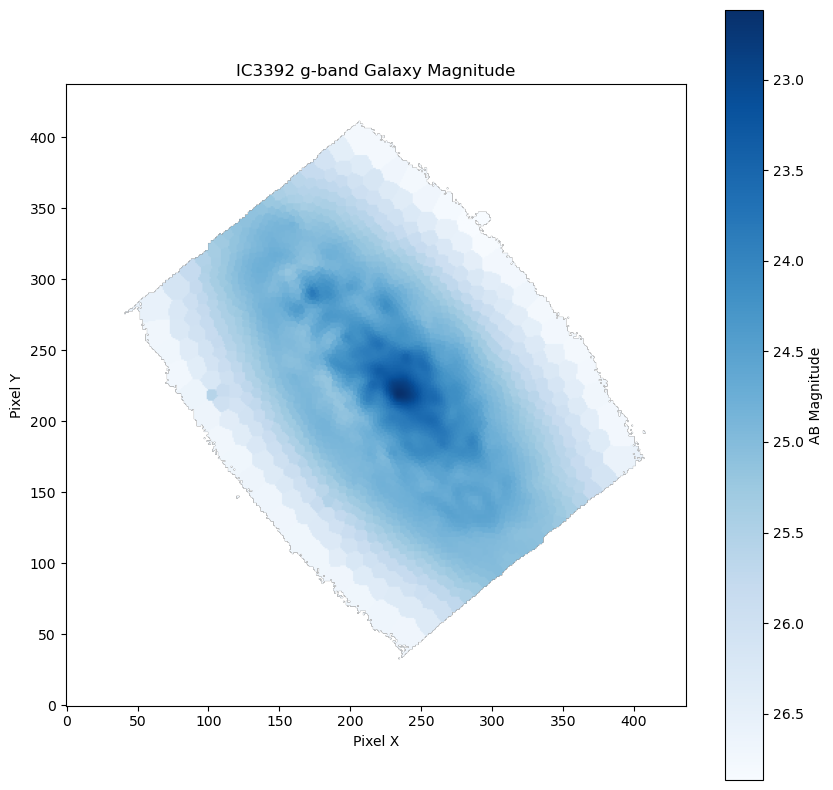

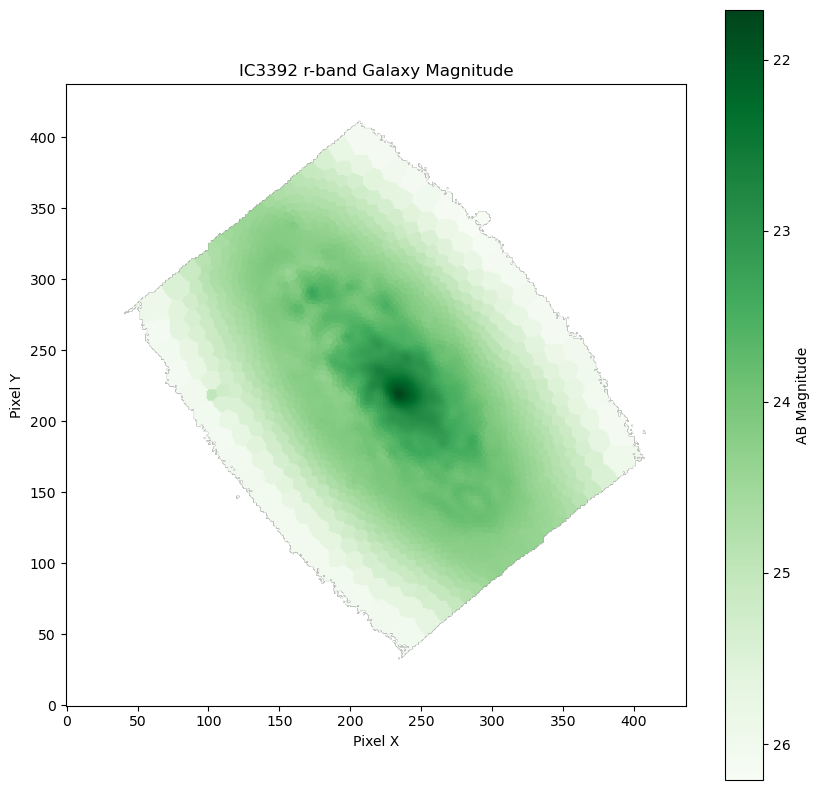

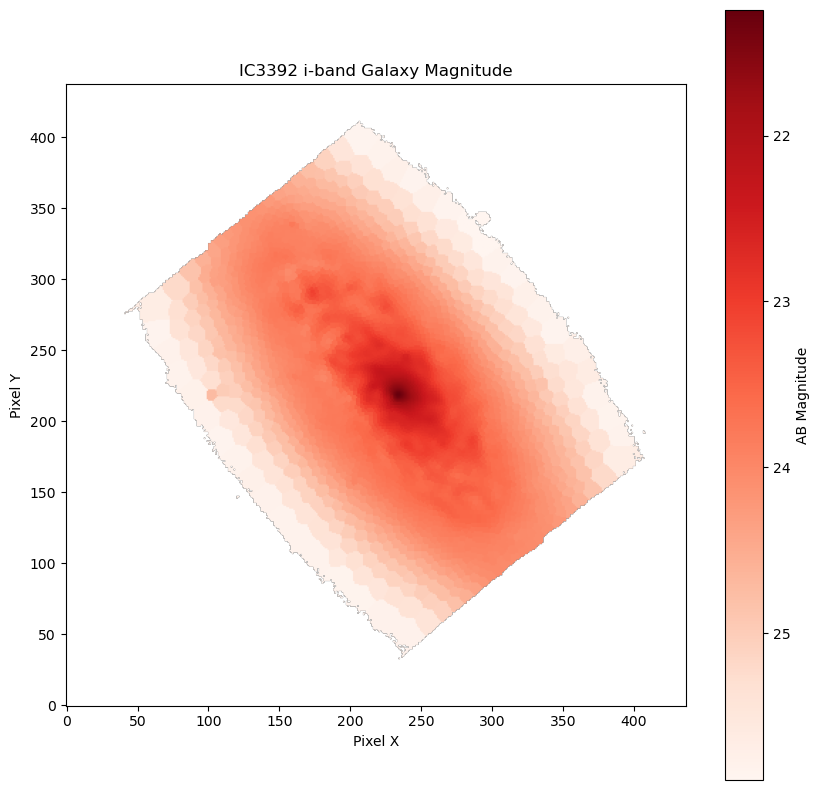

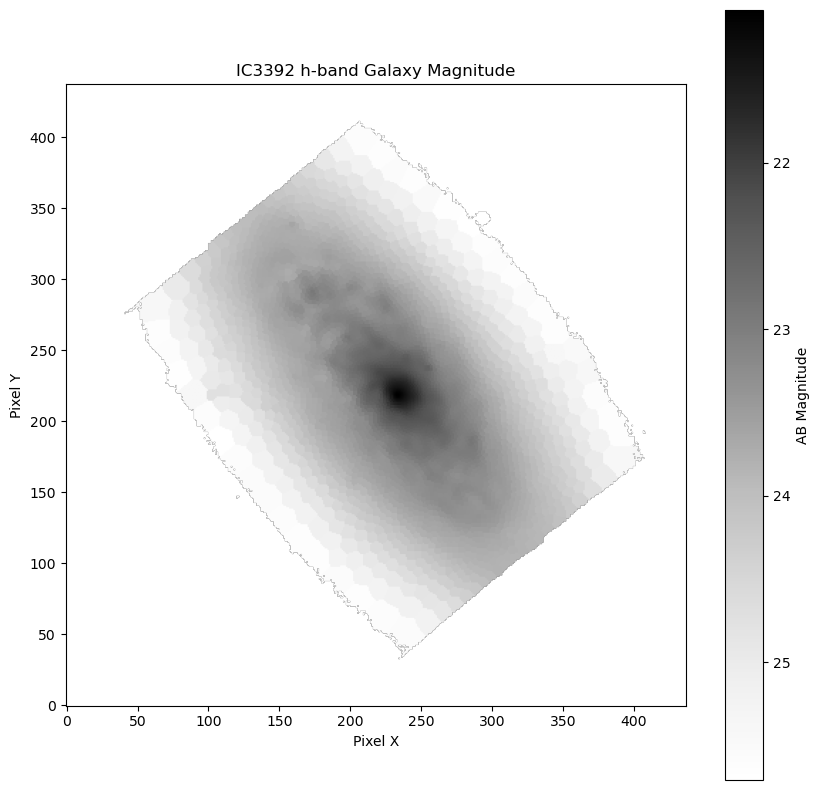

Total g-band flux: 6637.5869140625 nanomaggies
Total r-band flux: 12773.5654296875 nanomaggies
Total i-band flux: 17017.291015625 nanomaggies
Total h-band flux: 20971.505859375 nanomaggies
Total g-band magnitude: 12.945
Total r-band magnitude: 12.234
Total i-band magnitude: 11.923
Total h-band magnitude: 11.696
Photometric g-band magnitude: 12.945
Photometric r-band magnitude: 12.234
Photometric i-band magnitude: 11.923
Photometric h-band magnitude: 11.696


In [13]:
# # Extract galaxy magnitude in g-band and i-band
# g_band_galaxy_magnitude = np.where(galaxy_combined_mask, g_band_magnitude, np.nan)
# r_band_galaxy_magnitude = np.where(galaxy_combined_mask, r_band_magnitude, np.nan)
# i_band_galaxy_magnitude = np.where(galaxy_combined_mask, i_band_magnitude, np.nan)
# h_band_galaxy_magnitude = np.where(galaxy_combined_mask, h_band_magnitude, np.nan)

# Skip countour if in binning
g_band_galaxy_magnitude = g_band_magnitude
r_band_galaxy_magnitude = r_band_magnitude
i_band_galaxy_magnitude = i_band_magnitude
h_band_galaxy_magnitude = h_band_magnitude

# Plot the extracted galaxy magnitude in g-band
plt.figure(figsize=(10, 10))
plt.imshow(g_band_galaxy_magnitude, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band Galaxy Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the extracted galaxy magnitude in r-band
plt.figure(figsize=(10, 10))
plt.imshow(r_band_galaxy_magnitude, cmap='Greens_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} r-band Galaxy Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the extracted galaxy magnitude in i-band
plt.figure(figsize=(10, 10))
plt.imshow(i_band_galaxy_magnitude, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band Galaxy Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the extracted galaxy magnitude in h-band
plt.figure(figsize=(10, 10))
plt.imshow(h_band_galaxy_magnitude, cmap='Greys_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} h-band Galaxy Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Extract the galaxy flux in g-band and i-band
g_band_galaxy_flux = np.where(galaxy_combined_mask, g_band_flux_corrected, np.nan)
r_band_galaxy_flux = np.where(galaxy_combined_mask, r_band_flux_corrected, np.nan)
i_band_galaxy_flux = np.where(galaxy_combined_mask, i_band_flux_corrected, np.nan)
h_band_galaxy_flux = np.where(galaxy_combined_mask, h_band_flux_corrected, np.nan)

# Calculate the total flux in g-band and i-band
g_band_galaxy_total_flux = np.nansum(g_band_galaxy_flux)
r_band_galaxy_total_flux = np.nansum(r_band_galaxy_flux)
i_band_galaxy_total_flux = np.nansum(i_band_galaxy_flux)
h_band_galaxy_total_flux = np.nansum(h_band_galaxy_flux)
print(f"Total g-band flux: {g_band_galaxy_total_flux} nanomaggies")
print(f"Total r-band flux: {r_band_galaxy_total_flux} nanomaggies")
print(f"Total i-band flux: {i_band_galaxy_total_flux} nanomaggies")
print(f"Total h-band flux: {h_band_galaxy_total_flux} nanomaggies")
# Calculate the total magnitude in g-band and i-band    
g_band_galaxy_total_magnitude = 22.5 - 2.5 * np.log10(g_band_galaxy_total_flux)
r_band_galaxy_total_magnitude = 22.5 - 2.5 * np.log10(r_band_galaxy_total_flux)
i_band_galaxy_total_magnitude = 22.5 - 2.5 * np.log10(i_band_galaxy_total_flux)
h_band_galaxy_total_magnitude = 22.5 - 2.5 * np.log10(h_band_galaxy_total_flux)
print(f"Total g-band magnitude: {g_band_galaxy_total_magnitude:.3f}")
print(f"Total r-band magnitude: {r_band_galaxy_total_magnitude:.3f}")
print(f"Total i-band magnitude: {i_band_galaxy_total_magnitude:.3f}")
print(f"Total h-band magnitude: {h_band_galaxy_total_magnitude:.3f}")

# Calculate the total photometric flux in g-band and i-band
g_band_photometric_flux = np.where(galaxy_g_mask, g_band_flux_corrected, np.nan)
r_band_photometric_flux = np.where(galaxy_r_mask, r_band_flux_corrected, np.nan)
i_band_photometric_flux = np.where(galaxy_i_mask, i_band_flux_corrected, np.nan)
h_band_photometric_flux = np.where(galaxy_h_mask, h_band_flux_corrected, np.nan)
# Calculate the total photometric magitude in g-band and i-band
g_band_photometric_magnitude = 22.5 - 2.5 * np.log10(np.nansum(g_band_photometric_flux))
r_band_photometric_magnitude = 22.5 - 2.5 * np.log10(np.nansum(r_band_photometric_flux))
i_band_photometric_magnitude = 22.5 - 2.5 * np.log10(np.nansum(i_band_photometric_flux))
h_band_photometric_magnitude = 22.5 - 2.5 * np.log10(np.nansum(h_band_photometric_flux))
print(f"Photometric g-band magnitude: {g_band_photometric_magnitude:.3f}")
print(f"Photometric r-band magnitude: {r_band_photometric_magnitude:.3f}")
print(f"Photometric i-band magnitude: {i_band_photometric_magnitude:.3f}")
print(f"Photometric h-band magnitude: {h_band_photometric_magnitude:.3f}")

In [14]:
# Universal distance lookup (in Mpc, Corteste et al. 2012)
distance_lookup = {
    "IC3392": 16.50,
    "NGC4383": 16.50, 
    "NGC4501": 16.50, 
    "NGC4192": 16.50, 
}
# fallback to 16.5 Mpc (distance of Virgo, Mei et al. 2007) if object_name not in the dict
distance_mpc = distance_lookup.get(object_name, 16.50)
distance_pc = distance_mpc * 1e6
DM = 5 * np.log10(distance_pc / 10.0)

# For NGC4383 in Cortese et al. 2012, the distance is 17.0 Mpc, g-band is 12.392, i-band is 11.654, override the values for testing
# g_band_galaxy_total_magnitude = 12.392
# i_band_galaxy_total_magnitude = 11.654

# Compute absolute magnitude in g-band
g_band_galaxy_Magnitude = g_band_galaxy_magnitude - DM
g_band_galaxy_total_Magnitude = g_band_galaxy_total_magnitude - DM
# Compute absolute magnitude in r-band
r_band_galaxy_Magnitude = r_band_galaxy_magnitude - DM
r_band_galaxy_total_Magnitude = r_band_galaxy_total_magnitude - DM
# Compute absolute magnitude in i-band
i_band_galaxy_Magnitude = i_band_galaxy_magnitude - DM
i_band_galaxy_total_Magnitude = i_band_galaxy_total_magnitude - DM
# Compute absolute magnitude in h-band
h_band_galaxy_Magnitude = h_band_galaxy_magnitude - DM
h_band_galaxy_total_Magnitude = h_band_galaxy_total_magnitude - DM

# Compute total luminosity in gri-band
g_band_galaxy_luminosity = 10**(0.4 * (5.12  - g_band_galaxy_Magnitude))  # M_{g,⊙}=5.12 mag :contentReference[oaicite:0]{index=0}
g_band_galaxy_total_luminosity = 10**(0.4 * (5.12  - g_band_galaxy_total_Magnitude))  # M_{g,⊙}=5.12 mag :contentReference[oaicite:0]{index=0}
r_band_galaxy_luminosity = 10**(0.4 * (4.64  - r_band_galaxy_Magnitude))  # M_{r,⊙}=4.68 mag :contentReference[oaicite:1]{index=1}
r_band_galaxy_total_luminosity = 10**(0.4 * (4.64  - r_band_galaxy_total_Magnitude))  # M_{r,⊙}=4.68 mag :contentReference[oaicite:1]{index=1}
i_band_galaxy_luminosity = 10**(0.4 * (4.53  - i_band_galaxy_Magnitude))  # M_{i,⊙}≈4.56 mag; AB zero‐point F_ν(0)=3631 Jy :contentReference[oaicite:2]{index=2}
i_band_galaxy_total_luminosity = 10**(0.4 * (4.53  - i_band_galaxy_total_Magnitude))  # M_{i,⊙}≈4.56 mag; AB zero‐point F_ν(0)=3631 Jy :contentReference[oaicite:2]{index=2}
h_band_galaxy_luminosity = 10**(0.4 * (4.70  - h_band_galaxy_Magnitude))  # M_{h,⊙}≈4.70 mag; AB zero‐point F_ν(0)=3631 Jy :contentReference[oaicite:2]{index=2}
h_band_galaxy_total_luminosity = 10**(0.4 * (4.70  - h_band_galaxy_total_Magnitude))  # M_{h,⊙}≈4.70 mag; AB zero‐point F_ν(0)=3631 Jy :contentReference[oaicite:2]{index=2}


print(f"Distance to {object_name}: {distance_mpc:.2f} Mpc")
print(f"Distance modulus to {object_name}: {DM:.2f}")
print(f"Total g-band magnitude: {g_band_galaxy_total_magnitude:.3f}")
print(f"Total r-band magnitude: {r_band_galaxy_total_magnitude:.3f}")
print(f"Total i-band magnitude: {i_band_galaxy_total_magnitude:.3f}")
print(f"Total h-band magnitude: {h_band_galaxy_total_magnitude:.3f}")
print(f"Total absolute g-band Magnitude: {g_band_galaxy_total_Magnitude:.2f}")
print(f"Total absolute r-band Magnitude: {r_band_galaxy_total_Magnitude:.2f}")
print(f"Total absolute i-band Magnitude: {i_band_galaxy_total_Magnitude:.2f}")
print(f"Total absolute h-band Magnitude: {h_band_galaxy_total_Magnitude:.2f}")
print(f"Total g-band total luminosity: {g_band_galaxy_total_luminosity:.2e} L_sun = log(L/L_sun) = {np.log10(g_band_galaxy_total_luminosity):.2f}")
print(f"Total r-band total luminosity: {r_band_galaxy_total_luminosity:.2e} L_sun = log(L/L_sun) = {np.log10(r_band_galaxy_total_luminosity):.2f}")
print(f"Total i-band total luminosity: {i_band_galaxy_total_luminosity:.2e} L_sun = log(L/L_sun) = {np.log10(i_band_galaxy_total_luminosity):.2f}")
print(f"Total h-band total luminosity: {h_band_galaxy_total_luminosity:.2e} L_sun = log(L/L_sun) = {np.log10(h_band_galaxy_total_luminosity):.2f}")

# Compute g-i color
g_minus_i_galaxy_magnitude = g_band_galaxy_magnitude - i_band_galaxy_magnitude
g_minus_i_galaxy_total_magnitude = g_band_galaxy_total_magnitude - i_band_galaxy_total_magnitude
print(f"Total g-i color: {g_minus_i_galaxy_total_magnitude:.3f}")

# Estimate log(M_*/M_\odot) using the g-i color (Taylot et al. 2011)
# log(M_*/M_\odot) = 1.15 + 0.7 * (g-i) - 0.4 * M_i
log_stellar_mass = 1.15 + 0.7 * g_minus_i_galaxy_magnitude - 0.4 * i_band_galaxy_Magnitude
stellar_mass = 10**log_stellar_mass
stellar_mass_sum = np.nansum(stellar_mass)
log_stellar_mass_sum = np.log10(stellar_mass_sum)
log_stellar_mass_total = 1.15 + 0.7 * g_minus_i_galaxy_total_magnitude - 0.4 * i_band_galaxy_total_Magnitude
stellar_mass_total = 10**log_stellar_mass_total

# i band mass to light ratio
# log(M_*/L_i) = -0.68 + 0.7 * (g-i) 
log_ML_i = -0.68 + 0.7 * g_minus_i_galaxy_total_magnitude
stellar_mass_to_L_i = 10**log_ML_i
print(f"Mass to light ratio in i-band: log({log_ML_i:.2f}) or {stellar_mass_to_L_i:.2f} M_sun/L_sun")

# Mass to light ratio in gri bands
ML_g = log_stellar_mass_sum - np.log10(g_band_galaxy_total_luminosity)
ML_r = log_stellar_mass_sum - np.log10(r_band_galaxy_total_luminosity)
ML_i = log_stellar_mass_sum - np.log10(i_band_galaxy_total_luminosity)
ML_h = log_stellar_mass_sum - np.log10(h_band_galaxy_total_luminosity)
print(f"Mass to light ratio in g-band: log({ML_g:.2f}) or {10**ML_g:.2f}")
print(f"Mass to light ratio in r-band: log({ML_r:.2f}) or {10**ML_r:.2f}")
print(f"Mass to light ratio in i-band: log({ML_i:.2f}) or {10**ML_i:.2f}")
print(f"Mass to light ratio in h-band: log({ML_h:.2f}) or {10**ML_h:.2f}")

# Estimate log(M_*/M_\odot) using the g-i color in Corteste et al. 2012, adopted from Zibetti et al. 2009
# log(M_*/M_\odot) = 0.869 + 1.032 * (g-i) - 0.4 * M_i
log_stellar_mass_toatl_luca = 0.869 + 1.032 * g_minus_i_galaxy_total_magnitude - 0.4 * i_band_galaxy_total_Magnitude
stellar_mass_toatl_luca = 10**log_stellar_mass_toatl_luca
print(f"Stellar mass sum up in {object_name}: {stellar_mass_sum:.2e} M_sun or log (M_*/M_sun) = {log_stellar_mass_sum:.2f}")
print(f"Stellar mass total in {object_name}: {stellar_mass_total:.2e} M_sun or log (M_*/M_sun) = {log_stellar_mass_total:.2f}")
print(f"Stellar mass total in {object_name} (Corteste et al. 2012): {stellar_mass_toatl_luca:.2e} M_sun or log (M_*/M_sun) = {log_stellar_mass_toatl_luca:.2f}")

Distance to IC3392: 16.50 Mpc
Distance modulus to IC3392: 31.09
Total g-band magnitude: 12.945
Total r-band magnitude: 12.234
Total i-band magnitude: 11.923
Total h-band magnitude: 11.696
Total absolute g-band Magnitude: -18.14
Total absolute r-band Magnitude: -18.85
Total absolute i-band Magnitude: -19.16
Total absolute h-band Magnitude: -19.39
Total g-band total luminosity: 2.02e+09 L_sun = log(L/L_sun) = 9.30
Total r-band total luminosity: 2.50e+09 L_sun = log(L/L_sun) = 9.40
Total i-band total luminosity: 3.01e+09 L_sun = log(L/L_sun) = 9.48
Total h-band total luminosity: 4.33e+09 L_sun = log(L/L_sun) = 9.64
Total g-i color: 1.022
Mass to light ratio in i-band: log(0.04) or 1.09 M_sun/L_sun
Mass to light ratio in g-band: log(0.24) or 1.73
Mass to light ratio in r-band: log(0.14) or 1.40
Mass to light ratio in i-band: log(0.06) or 1.16
Mass to light ratio in h-band: log(-0.09) or 0.80
Stellar mass sum up in IC3392: 3.49e+09 M_sun or log (M_*/M_sun) = 9.54
Stellar mass total in IC339

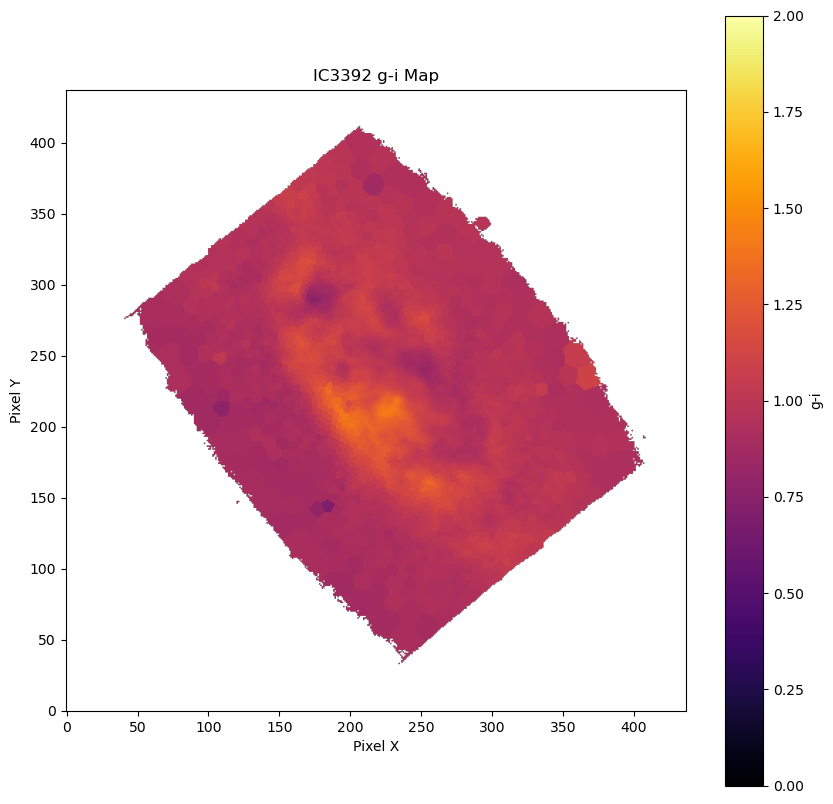

In [15]:
# Visualize g-i color map
plt.figure(figsize=(10, 10))
plt.imshow(g_minus_i_galaxy_magnitude, origin='lower', cmap='inferno', vmin=0, vmax=2)
cbar = plt.colorbar(label='g-i')
plt.title(f"{object_name} g-i Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

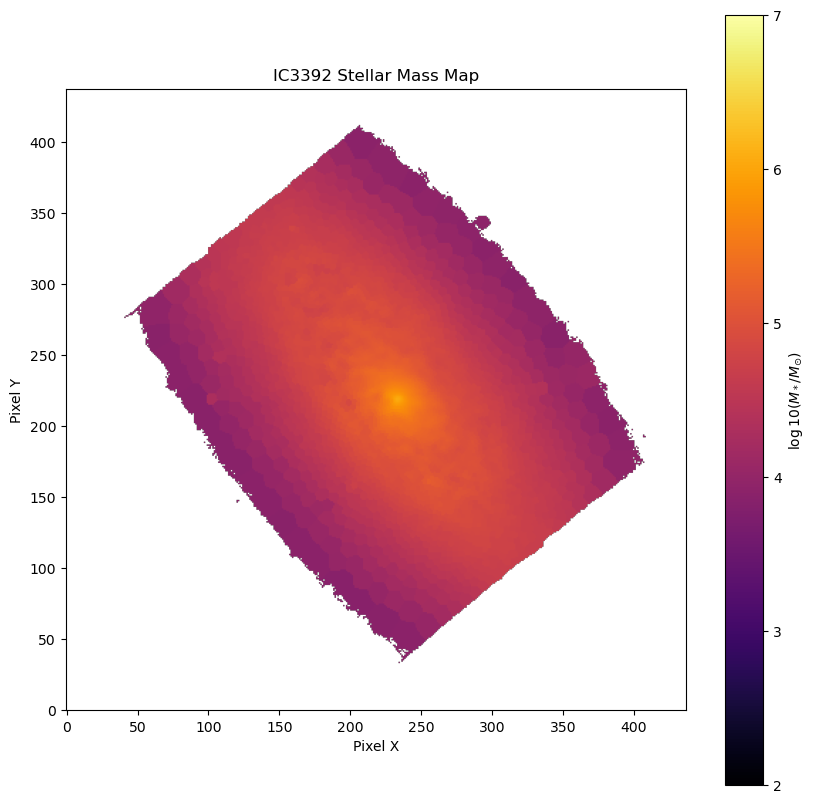

In [16]:
# Visualize the stellar mass distribution
plt.figure(figsize=(10, 10))
plt.imshow(log_stellar_mass, origin='lower', cmap='inferno', vmin=2, vmax=7)
cbar = plt.colorbar(label=r'$\log{10}(M_*/M_{\odot})$')
plt.title(f"{object_name} Stellar Mass Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

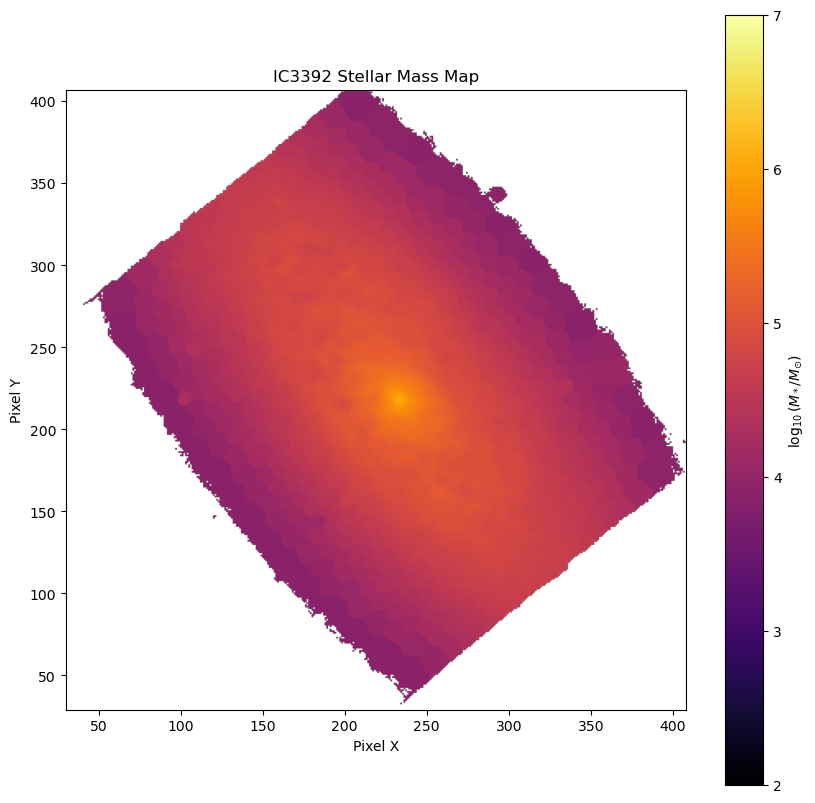

In [17]:
# find bounding box of finite pixels
nonnan = ~np.isnan(log_stellar_mass)
ys, xs = np.where(nonnan)
ymin, ymax = ys.min(), ys.max()
xmin, xmax = xs.min(), xs.max()

# compute half-widths of that box
half_w = (xmax - xmin) // 2
half_h = (ymax - ymin) // 2

# integer center from previous fit
cx_i, cy_i = log_stellar_mass.shape
cx_i = cx_i // 2
cy_i = cy_i // 2

# build zoom window centered on (cx, cy)
xmin_zoom = max(cx_i - half_w, 0)
xmax_zoom = min(cx_i + half_w, log_stellar_mass.shape[1] - 1)
ymin_zoom = max(cy_i - half_h, 0)
ymax_zoom = min(cy_i + half_h, log_stellar_mass.shape[0] - 1)

half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

plt.figure(figsize=(10, 10))
im = plt.imshow(log_stellar_mass, origin='lower', cmap='inferno', vmin=2, vmax=7)
plt.colorbar(im, label=r'$\log_{10}(M_*/M_{\odot})$')

plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"{object_name} Stellar Mass Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

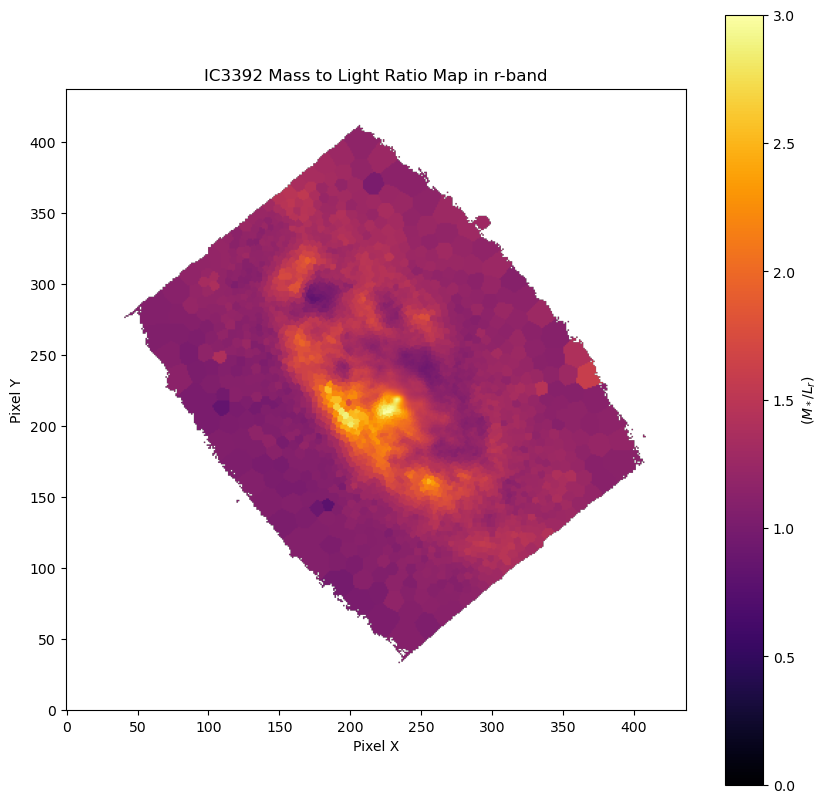

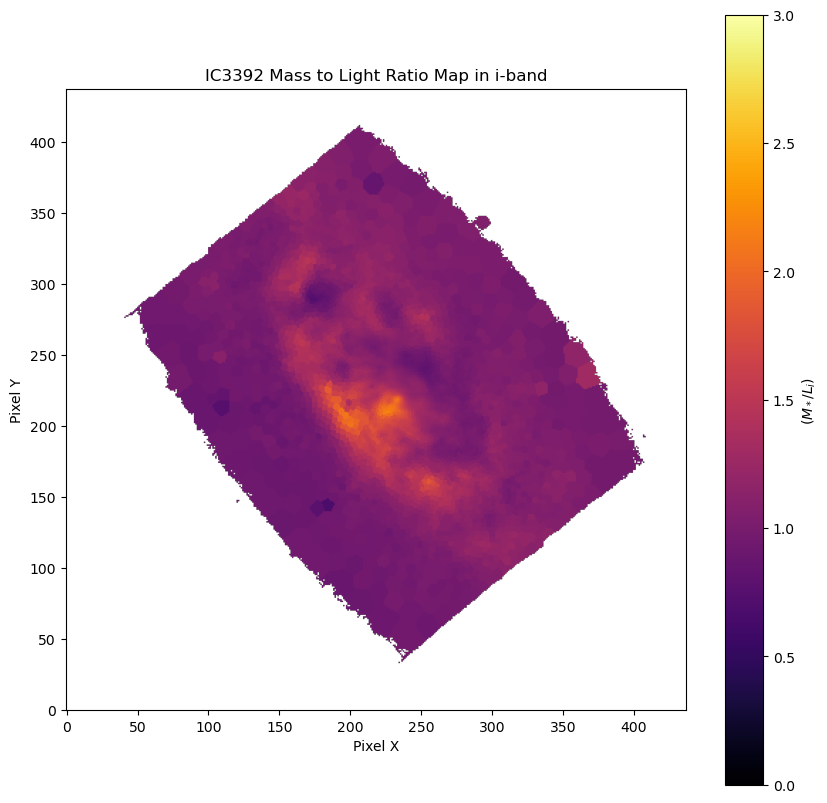

In [18]:
# Mass to light ratio map
ML_g_map = stellar_mass/g_band_galaxy_luminosity
ML_r_map = stellar_mass/r_band_galaxy_luminosity
ML_i_map = stellar_mass/i_band_galaxy_luminosity
ML_h_map = stellar_mass/h_band_galaxy_luminosity

# Plot the mass to light ratio map in r-band
plt.figure(figsize=(10, 10))
plt.imshow(ML_r_map, origin='lower', cmap='inferno', vmin=0, vmax=3)
cbar = plt.colorbar(label=r'$(M_*/L_r)$')
plt.title(f"{object_name} Mass to Light Ratio Map in r-band")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Plot the mass to light ratio map in i-band
plt.figure(figsize=(10, 10))
plt.imshow(ML_i_map, origin='lower', cmap='inferno', vmin=0, vmax=3)
cbar = plt.colorbar(label=r'$(M_*/L_i)$')
plt.title(f"{object_name} Mass to Light Ratio Map in i-band")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()


In [19]:
# 1) Paths
in_fn  = "IC3392_legacy_voronoi_binned_extended.fits"
out_fn = "IC3392_legacy_voronoi_binned_extended.fits"  # overwrite same file

# 2) Load the existing file and grab its FLUX header for WCS
hdul = fits.open(in_fn, mode='update')
wcs_hdr = hdul['FLUX'].header.copy()

# 3) Stack your M/L maps into a (4, ny, nx) cube
ML_stack = np.stack([
    ML_g_map,
    ML_r_map,
    ML_i_map,
    ML_h_map
], axis=0).astype(np.float32)

# 4) Make the new IMAGE extension
hdu_ml = fits.ImageHDU(
    data   = ML_stack,
    header = wcs_hdr,
    name   = 'ML'
)
hdu_ml.header['BUNIT'] = 'M_sun/L_sun'

# 5) Append and write out
hdul.append(hdu_ml)
hdul.flush()
hdul.close()

print("✔  Appended ML cube to", out_fn)


✔  Appended ML cube to IC3392_legacy_voronoi_binned_extended.fits


In [20]:
# File to update
fn = "IC3392_legacy_voronoi_binned_extended.fits"

# 1) Open in update mode and grab the FLUX header for WCS
hdul = fits.open(fn, mode='update')
wcs_hdr = hdul['FLUX'].header.copy()

# # 2) Compute your log‐stellar‐mass array (2D, same shape as g/r/i/h)
# //—for example, if you have a stellar_mass array in M_sun units:
# log_mass = np.log10(stellar_mass).astype(np.float32)

# 3) Wrap it in an ImageHDU
hdu_logM = fits.ImageHDU(
    data   = log_stellar_mass,
    header = wcs_hdr,
    name   = 'M'
)
hdu_logM.header['BUNIT'] = 'log(M_sun)'

# 4) Append and write
hdul.append(hdu_logM)
hdul.flush()
hdul.close()

print("Appended log-stellar-mass HDU ‘M’ with unit log(M_sun).")


Appended log-stellar-mass HDU ‘M’ with unit log(M_sun).


In [21]:
np.nanmin(r_band_galaxy_magnitude), np.nanmax(r_band_galaxy_magnitude)

(np.float32(21.708197), np.float32(26.210392))

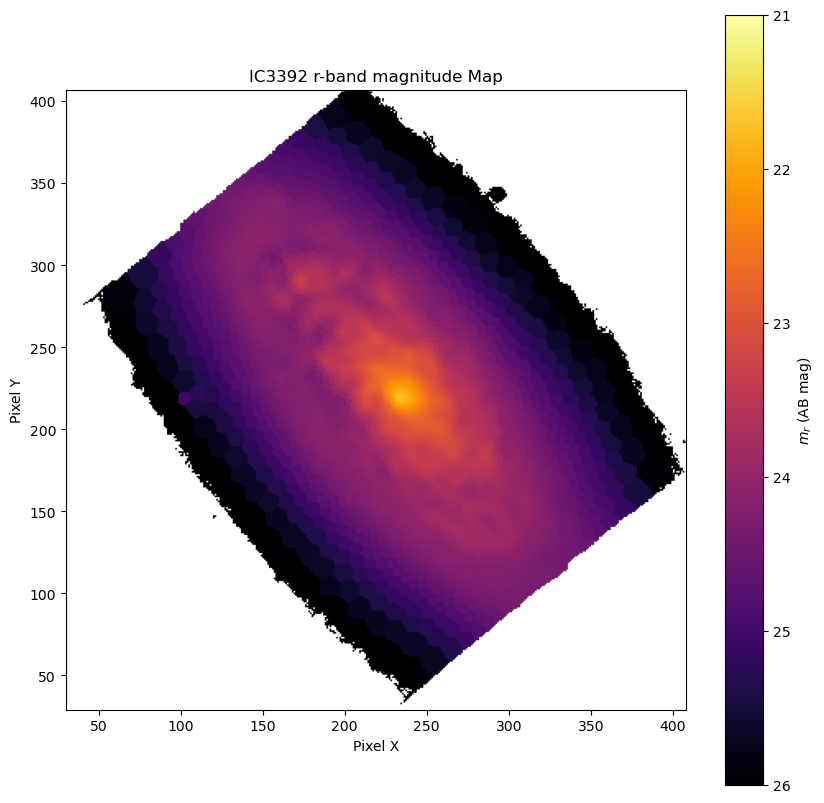

In [22]:
# find bounding box of finite pixels
nonnan = ~np.isnan(r_band_galaxy_magnitude)
ys, xs = np.where(nonnan)
ymin, ymax = ys.min(), ys.max()
xmin, xmax = xs.min(), xs.max()

# compute half-widths of that box
half_w = (xmax - xmin) // 2
half_h = (ymax - ymin) // 2

# integer center from previous fit
cx_i, cy_i = r_band_galaxy_magnitude.shape
cx_i = cx_i // 2
cy_i = cy_i // 2

# build zoom window centered on (cx, cy)
xmin_zoom = max(cx_i - half_w, 0)
xmax_zoom = min(cx_i + half_w, r_band_galaxy_magnitude.shape[1] - 1)
ymin_zoom = max(cy_i - half_h, 0)
ymax_zoom = min(cy_i + half_h, r_band_galaxy_magnitude.shape[0] - 1)

half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

plt.figure(figsize=(10, 10))
im = plt.imshow(r_band_galaxy_magnitude, origin='lower', cmap='inferno_r', vmin=21, vmax=26)
plt.colorbar(im, label=r'$m_r$ (AB mag)').ax.invert_yaxis()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 r-band magnitude Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [23]:
magnitude_stack = np.stack([
    g_band_galaxy_magnitude,
    r_band_galaxy_magnitude,
    i_band_galaxy_magnitude,
    h_band_galaxy_magnitude
], axis=0).astype(np.float32)
with fits.open("IC3392_legacy_voronoi_binned_extended.fits", mode="update") as hdul:
    hdu_mag = fits.ImageHDU(
        data   = magnitude_stack,
        header = wcs_hdr,
        name   = "MAGNITUDE"           # descriptive HDU name
    )
    hdu_mag.header["BUNIT"] = "mag_AB"
    hdu_mag.header["BANDS"] = "grih"   # self-documentation
    hdul.append(hdu_mag)
    hdul.flush()
print("✓  Added 4-band MAGNITUDE cube (g,r,i,h).")


✓  Added 4-band MAGNITUDE cube (g,r,i,h).


In [24]:
# uncorrected magnitudes
g_band_magnitude_uncorrected = 22.5 - 2.5 * np.log10(np.where(g_band_flux <= 0, np.nan, g_band_flux))
r_band_magnitude_uncorrected = 22.5 - 2.5 * np.log10(np.where(r_band_flux <= 0, np.nan, r_band_flux))
i_band_magnitude_uncorrected = 22.5 - 2.5 * np.log10(np.where(i_band_flux <= 0, np.nan, i_band_flux))
h_band_magnitude_uncorrected = 22.5 - 2.5 * np.log10(np.where(h_band_flux <= 0, np.nan, h_band_flux))

# Save uncorrected magnitudes to FITS
uncorrected_magnitude_stack = np.stack([
    g_band_magnitude_uncorrected,
    r_band_magnitude_uncorrected,
    i_band_magnitude_uncorrected,
    h_band_magnitude_uncorrected
], axis=0).astype(np.float32)
with fits.open("IC3392_legacy_voronoi_binned_extended.fits", mode="update") as hdul:
    hdu_uncorrected_mag = fits.ImageHDU(
        data   = uncorrected_magnitude_stack,
        header = wcs_hdr,
        name   = "MAGNITUDE_UNCORRECTED"  # descriptive HDU name
    )
    hdu_uncorrected_mag.header["BUNIT"] = "mag_AB"
    hdu_uncorrected_mag.header["BANDS"] = "grih"   # self-documentation
    hdul.append(hdu_uncorrected_mag)
    hdul.flush()
print("✓  Added 4-band MAGNITUDE_UNCORRECTED cube (g,r,i,h).")

✓  Added 4-band MAGNITUDE_UNCORRECTED cube (g,r,i,h).


In [25]:
22.5 - 2.5 * np.log10(np.nansum(np.where(r_band_flux <= 0, np.nan, r_band_flux)))

np.float32(12.314082)